## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')



2025-05-28 22:41:34.177206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 22:41:34.440989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 22:41:34.441091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 22:41:34.482129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 22:41:34.574133: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# # Load feature view and feature groups
# feature_view = fs.get_feature_view(name='event_retrieval', version=1)
# users_df = fs.get_feature_group("users", version=1).read()
# events_df = fs.get_feature_group("events", version=1).read()
# interactions_df = fs.get_feature_group("interactions", version=1).read()

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [2]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-05-28 22:41:40,296 INFO: Initializing external client
2025-05-28 22:41:40,298 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-28 22:41:41,636 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [4]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [3]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

In [ ]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [6]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/event_retrieval/version/1


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [4]:
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1,
)

In [5]:

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (16.53s) 


In [1]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load the datasets
# events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/events")
# users_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/users.csv")
# interactions_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/interactions.csv")
# events_df.rename(columns={"category":"event_type"}, inplace=True)
# # Merge the datasets
# merged_data = interactions_df.merge(events_df, on="event_id").merge(users_df, on="user_id",suffixes=("","_user"))

# # Split the merged data into train and test sets
# train_df, temp_df = train_test_split(merged_data, test_size=0.2, random_state=42)  # 80% train, 20% temp
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 50% val and 50% test

# # Identify cold start users and events
# cold_start_events = events_df[~events_df['event_id'].isin(train_df['event_id'])]["event_id"].tolist()
# cold_start_users = users_df[~users_df['user_id'].isin(train_df['user_id'])]["user_id"].tolist()


# cold_start_combined = merged_data[(merged_data["event_id"].isin (cold_start_events)) |\
#                                   (merged_data["user_id"].isin (cold_start_users))]

# print(len(cold_start_combined))
# # # Print the combined cold start DataFrame
# # cold_start_combined.head()





36


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [7]:
# Improved Two-Tower Model with Enhanced Regularization
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import numpy as np

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


# Reduced embedding dimension
EMBED_DIM = 32  
BATCH_SIZE = 1024
L2_REG = 0.01  
DROPOUT_RATE = 0.5  

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()
test_ds = df_to_ds(test_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,
            output_mode='multi_hot'
        )

        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=101,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=10  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=501, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)
    
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.batch(BATCH_SIZE).map(
            lambda x: (x["event_id"], self.item_model(x))
        )

        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )
    def call(self, features):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}
        return self.query_model(query_inputs), self.item_model(item_inputs)

    
    def compute_loss(self, features, training=False):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}

        query_embeddings = self.query_model(query_inputs, training=training)
        item_embeddings = self.item_model(item_inputs, training=training)

        return self.task(query_embeddings, item_embeddings)


# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4,  # Reduced from 1e-3
        decay_steps=10000
    ),
    weight_decay=0.01,  # Increased from 0.004
    clipnorm=1.0
)

model.compile(optimizer=optimizer)

# Train with early stopping and learning rate reduction
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=10,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    test_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

✅ Training set size: 445000
📌 Unique Users: 49908, Events: 9999
Epoch 1/10
435/435 [==============================] - 108s 236ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2746 - factorized_top_k/top_5_categorical_accuracy: 0.4476 - factorized_top_k/top_10_categorical_accuracy: 0.4704 - factorized_top_k/top_50_categorical_accuracy: 0.4862 - factorized_top_k/top_100_categorical_accuracy: 0.4888 - loss: 9570.0045 - regularization_loss: 5.3129 - total_loss: 9575.3173 - val_factorized_top_k/top_1_categorical_accuracy: 0.2708 - val_factorized_top_k/top_5_categorical_accuracy: 0.6204 - val_factorized_top_k/top_10_categorical_accuracy: 0.6204 - val_factorized_top_k/top_50_categorical_accuracy: 0.6204 - val_factorized_top_k/top_100_categorical_accuracy: 0.6204 - val_loss: 5717.9614 - val_regularization_loss: 3.3704 - val_total_loss: 5721.3320 - lr: 4.9768e-04
Epoch 2/10
435/435 [==============================] - 98s 223ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4993 - 

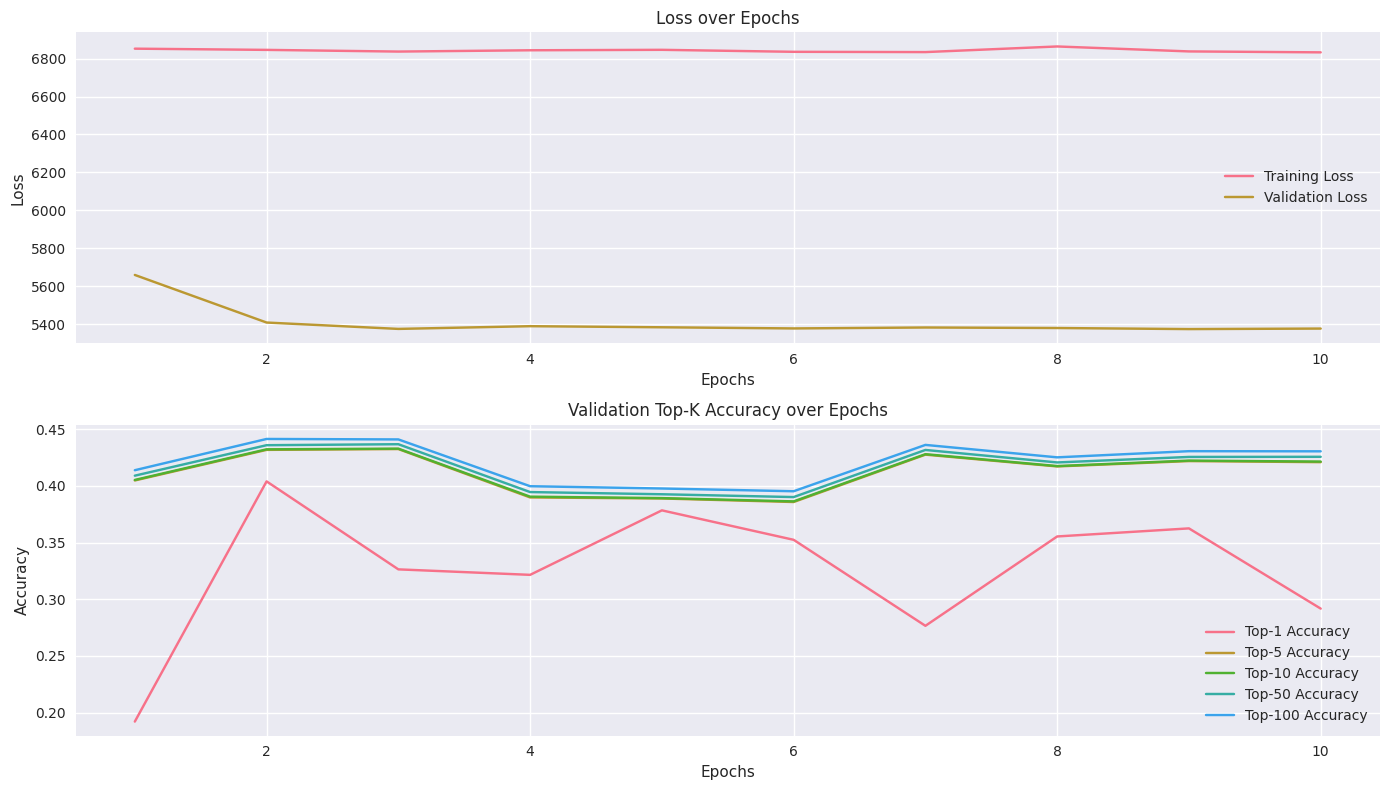

In [9]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(model_history.history)


In [10]:
import os
os.makedirs("model_checkpoints", exist_ok=True)

# Save weights
model.save_weights("model_checkpoints/two_tower_weights")

In [4]:
query_df = train_df[QUERY_FEATURES]


In [5]:
import hopsworks

project = hopsworks.login()
mr = project.get_model_registry()

2025-05-27 17:09:58,500 INFO: Initializing external client
2025-05-27 17:09:58,500 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-27 17:09:59,962 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


In [11]:
import tensorflow as tf

# Connect to Hopsworks Model Registry
mr = project.get_model_registry()

# Create a wrapper module for the query model
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "user_id": instances["user_id"],
            "user_city": instances["user_city"],
            "age": instances["age"],
            "user_interests": instances["user_interests"],
            "query_emb": query_emb,
        }

# Wrap query_model
query_model = QueryModelModule(model.query_model)

In [ ]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

In [12]:
# Define the input specifications for the instances
instances_spec = {
    'user_id': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_id'),   # Specification for user IDs
    'user_city': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_city'),    # Specification for user city
    'user_interests': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_interests'), # Specification for user interests
    'age': tf.TensorSpec(shape=(None,), dtype=tf.int64, name='age'),              # Specification for age
}

# Get the concrete function for the query_model's compute_emb function using the specified input signatures
signatures = query_model.compute_emb.get_concrete_function(instances_spec)

# Save the query_model along with the concrete function signatures
tf.saved_model.save(
    query_model,           # The model to save
    "query_model",         # Path to save the model
    signatures=signatures, # Concrete function signatures to include
)

tf.saved_model.save(
    model.item_model,    # The model to save
    "candidate_model",   # Path to save the model
)

2025-05-21 12:47:33,469 INFO: Function `compute_emb` contains input name(s) table_handle, 43153, 43163, 43179, resource with unsupported characters which will be renamed to query_tower_sequential_string_lookup_none_lookup_lookuptablefindv2_table_handle, query_tower_embedding_2_embedding_lookup_43153, query_tower_sequential_1_embedding_1_embedding_lookup_43163, query_tower_sequential_embedding_embedding_lookup_43179, query_tower_sequential_2_dense_1_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model/assets
2025-05-21 12:47:41,021 INFO: Assets written to: query_model/assets
INFO:tensorflow:Assets written to: candidate_model/assets
2025-05-21 12:47:44,098 INFO: Assets written to: candidate_model/assets


In [15]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

query_df = train_df[QUERY_FEATURES]

# Infer input schema from data.
query_model_input_schema = Schema(query_df)

# Manually specify output schema.
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

query_model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'user_id', 'type': 'object'},
   {'name': 'user_city', 'type': 'object'},
   {'name': 'age', 'type': 'int64'},
   {'name': 'user_interests', 'type': 'object'}]},
 'output_schema': {'tensor_schema': [{'name': 'query_embedding',
    'shape': '[32]',
    'type': 'float32'}]}}

In [16]:
# Sample a query example from the query DataFrame
query_example = query_df.sample().to_dict("records")

# Create a tensorflow model for the query_model in the Model Registry 
mr_query_model = mr.tensorflow.create_model(
    name="query_model",                                           # Name of the model
    description="Model that generates query embeddings from user features",  # Description of the model
    input_example=query_example,                                  # Example input for the model
    model_schema=query_model_schema,                              # Schema of the model
)

# Save the query_model to the Model Registry
mr_query_model.save("query_model")                                # Path to save the model

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/fingerprint.pb: 0.000%|          | 0…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/saved_model.pb: 0.000%|          | 0…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/variables/variables.index: 0.000%|  …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/variables/variables.data-00000-of-00…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/input_example.json: 0.000%|          | 0/106 ela…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/model_schema.json: 0.000%|          | 0/494 elap…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/query_model/1


Model(name: 'query_model', version: 1)

In [17]:
# Define the input schema for the candidate_model based on item_df
candidate_model_input_schema = Schema(item_df)

# Define the output schema for the candidate_model, specifying the shape and type of the output
candidate_model_output_schema = Schema([{
    "name": "candidate_embedding",   # Name of the output feature
    "type": "float32",               # Data type of the output feature
    "shape": [EMBED_DIM],              # Shape of the output feature
}])

# Combine the input and output schemas to create the overall model schema for the candidate_model
candidate_model_schema = ModelSchema(
    input_schema=candidate_model_input_schema,    # Input schema for the model
    output_schema=candidate_model_output_schema,  # Output schema for the model
)

# Sample a candidate example from the item DataFrame
candidate_example = item_df.sample().to_dict("records")

# Create a tensorflow model for the candidate_model in the Model Registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",                                        # Name of the model
    description="Model that generates candidate embeddings from video features",  # Description of the model
    input_example=candidate_example,                              # Example input for the model
    model_schema=candidate_model_schema,                          # Schema of the model
)

# Save the candidate_model to the Model Registry
mr_candidate_model.save("candidate_model")                        # Path to save the model

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/fingerprint.pb: 0.000%|         …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/saved_model.pb: 0.000%|         …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/variables/variables.index: 0.000…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/variables/variables.data-00000-o…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/input_example.json: 0.000%|          | 0/158 ela…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/model_schema.json: 0.000%|          | 0/499 elap…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

---

# Model implementation to compare with baseline models

In [10]:
users_df = users_fg.read()
interactions_df = interactions_fg.read()
events_df = events_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.09s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


In [15]:
events_df.columns

Index(['event_id', 'title', 'event_type', 'event_lat', 'event_lon',
       'event_city', 'start_time', 'duration', 'weather_condition',
       'temperature', 'precipitation', 'attendance_rate',
       'event_indoor_capability'],
      dtype='object')

In [11]:
unique_users = test_df["user_id"].unique()
unique_events = test_df["event_id"].unique()

test_users_df = users_df[users_df["user_id"].isin(unique_users)]
test_events_df = events_df[events_df["event_id"].isin(unique_events)]
test_interactions_df = interactions_df.merge(test_users_df, on='user_id',suffixes=("", "_user")).merge(test_events_df, on='event_id') 
len(test_interactions_df)

24071

In [12]:
test_df.head()

interaction_id user_id user_city  age              user_interests  \
69          FA828W  GX135E     Dubai   31  tech,literature,travel,art   
115         WB100J  GF696C  New York   40                 art,fitness   
120         KA672G  BK295N  New York   29               music,fitness   
151         UZ688A  JP812E     Tokyo   51                 food,travel   
154         TH278E  YX655C  New York   48             literature,food   

    event_id event_city             event_type  \
69    RE932F      Dubai       Sports & Fitness   
115   XK338E   New York  Immersive Experiences   
120   SI482B   New York   Education & Learning   
151   DA914V      Tokyo  Business & Networking   
154   YI400R   New York         Arts & Culture   

                                                 title  
69   Assimilated bifurcated support Sports & Fitnes...  
115  Public-key stable leverage Immersive Experienc...  
120  Customer-focused optimizing hardware Education...  
151  Public-key content-based hub Business & Networ...  
154  Face-to-face real-time framework Arts & Cultur...

user_id	user_lat	user_lon	user_city	indoor_outdoor_preference	age	user_interests	signup_date	social_connectedness	user_weather_condition	user_temperature	user_precipitation
0	AQ338K	52.241015	13.459565	Berlin	indoor	30	cinema,music	2024-03-17 22:30:14.832216	9	Clear	16.2	0.00
1	CD426N	40.867704	-74.428504	New York	outdoor	27	literature,food	2024-12-13 18:20:53.459834	15	Clear	17.6	0.00
2	QI727I	18.942333	73.106038	Mumbai	indoor	43	travel,tech,cinema	2024-11-16 11:29:23.799025	17	Clear	30.9	0.00

event_data:
	event_id	title	event_type	event_lat	event_lon	event_city	start_time	duration	weather_condition	temperature	precipitation	attendance_rate	event_indoor_capability
0	CT562P	Multi-lateral grid-enabled projection Food & D...	Food & Drink	25.618944	55.021470	Dubai	2025-10-13 19:22:42.607925	360	Rain	30.6	17.8	42.337118	False
1	YH404F	Enhanced global success Music & Concerts in Sã...	Music & Concerts	-23.578485	-46.967296	São Paulo	2025-06-02 09:29:23.265920	480	Clear	27.2	0.0	17.000775	False
2	DZ892D	Synchronized contextually-based website Commun...	Community & Causes	35.647417	140.011295	Tokyo	2025-08-28 09:50:01.262192	120	Rain	17.2	17.8	37.947901	False
interactions_data:
	interaction_id	user_id	event_id	interaction_type	interaction_time	interaction_distance_to_event	interaction_label
0	ZO876H	LE249D	WI267T	invited & yes	2025-07-14 13:52:54.424219	35.780941	1
1	WY612T	OX425G	UX026V	yes	2025-06-14 16:14:17.087184	45.737197	1
2	JK762E	LK101E	PT796Q	yes	2025-09-10 17:42:21.285635	57.109282	1
3	EV784M	ID377X	SN272D	no	2025-05-31 20:49:12.332649	36.805831	0
4	PW558S	TR667Y	WR018Q	yes	2025-07-17 00:29:41.991505	74.335308	1

test_df:
interaction_id	user_id	user_city	age	user_interests	event_id	event_city	event_type	title
69	FA828W	GX135E	Dubai	31	tech,literature,travel,art	RE932F	Dubai	Sports & Fitness	Assimilated bifurcated support Sports & Fitnes...
115	WB100J	GF696C	New York	40	art,fitness	XK338E	New York	Immersive Experiences	Public-key stable leverage Immersive Experienc...
120	KA672G	BK295N	New York	29	music,fitness	SI482B	New York	Education & Learning	Customer-focused optimizing hardware Education...

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier, Pool
import joblib
from datetime import datetime

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and setup ---

unique_users = test_df["user_id"].unique()
unique_events = test_df["event_id"].unique()

test_users_df = users_df[users_df["user_id"].isin(unique_users)]
test_events_df = events_df[events_df["event_id"].isin(unique_events)]
test_interactions_df = interactions_df.merge(
    test_users_df, on='user_id', suffixes=("", "_user")
).merge(
    test_events_df, on='event_id'
)

QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

NO_WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city',
    'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
    'user_interests', 'interaction_label'
]

WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 
    'weather_condition', 'temperature', 'attendance_rate',
    'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
    'age', 'user_interests', 'user_weather_condition', 'user_temperature', 'user_precipitation',
    'precipitation', 'interaction_label'
]

test_interactions = test_interactions_df
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = test_users_df[test_users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = test_events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings).astype('float32'), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.3
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    k_values = [1, 10, 50, 100]
    ndcg_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    mrr = []
    all_scores = []
    all_labels = []
    user_metrics = []
    total_users = 0
    successful_users = 0

    user_groups = test_interactions.groupby('user_id')
    for idx, (user_id, group) in enumerate(user_groups):
        try:
            if idx % 100 == 0:
                print(f"Processing user {idx+1}/{len(user_groups)} (user_id={user_id})...")
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='left'
            )
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)
            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            y_true = [1 if eid in attended_events else 0 for eid in final_recommendation_ids]
            y_score = ranked_results['ranking_score'].values[:max_k]
            # For histogram
            all_scores.extend(list(y_score))
            all_labels.extend(list(y_true))
            # Per-user metrics for CSV
            user_metric_row = {'user_id': user_id}
            for k in k_values:
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall = hits / len(attended_events)
                precision = hits / k
                dcg = 0.0
                for idx2, eid in enumerate(final_recommendation_ids[:k]):
                    if eid in attended_events:
                        dcg += 1 / np.log2(idx2 + 2)
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(attended_events), k)))
                ndcg = dcg / idcg if idcg > 0 else 0.0
                recall_at_k[k].append(recall)
                precision_at_k[k].append(precision)
                ndcg_at_k[k].append(ndcg)
                user_metric_row[f"Recall@{k}"] = recall
                user_metric_row[f"Precision@{k}"] = precision
                user_metric_row[f"NDCG@{k}"] = ndcg
            rr = 0.0
            for idx2, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    rr = 1.0 / (idx2 + 1)
                    break
            mrr.append(rr)
            ap = average_precision_score(y_true, y_score) if sum(y_true) > 0 else 0.0
            user_metric_row["MRR"] = rr
            user_metric_row["Average_Precision"] = ap
            user_metrics.append(user_metric_row)
            successful_users += 1
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    metrics_dict = {
        "K": [],
        "Recall": [],
        "Precision": [],
        "NDCG": []
    }
    for k in k_values:
        recall = np.mean(recall_at_k[k]) if recall_at_k[k] else 0.0
        precision = np.mean(precision_at_k[k]) if precision_at_k[k] else 0.0
        ndcg = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0.0
        print(f"Recall@{k}: {recall:.4f}")
        print(f"Precision@{k}: {precision:.4f}")
        print(f"NDCG@{k}: {ndcg:.4f}")
        metrics_dict["K"].append(k)
        metrics_dict["Recall"].append(recall)
        metrics_dict["Precision"].append(precision)
        metrics_dict["NDCG"].append(ndcg)
    mrr_val = np.mean(mrr) if mrr else 0.0
    avg_precision = np.mean([row["Average_Precision"] for row in user_metrics]) if user_metrics else 0.0
    print(f"MRR: {mrr_val:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df["MRR"] = mrr_val
    metrics_df["Average_Precision"] = avg_precision
    # Visual display (metrics)
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_dict["K"], metrics_dict["Recall"], marker='o', label='Recall')
    plt.plot(metrics_dict["K"], metrics_dict["Precision"], marker='s', label='Precision')
    plt.plot(metrics_dict["K"], metrics_dict["NDCG"], marker='^', label='NDCG')
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.title("Retrieval-Ranking Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Visual display (score distribution)
    plt.figure(figsize=(8,5))
    plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=20, alpha=0.7, label='Relevant (label=1)')
    plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=20, alpha=0.7, label='Irrelevant (label=0)')
    plt.xlabel('Ranking Score')
    plt.ylabel('Count')
    plt.title('Distribution of Ranking Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()
    results_dataframe = pd.DataFrame(user_metrics)
    return {
        "mrr": mrr_val,
        "average_precision": avg_precision,
        "metrics_df": metrics_df,
        "results_dataframe": results_dataframe
    }

# --- Main function that runs both ranking models ---
def main():
    # Load your models here
    print("Loading models...")
    query_model = model.query_model
    candidate_model = model.item_model
    ranking_model_weather = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")      # update path
    ranking_model_no_weather = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")# update path

    # Run pipeline for NO-WEATHER model
    print("\n----- Running pipeline: No-Weather Ranking Model -----")
    integrated_retrieval_ranking_pipeline(
        query_model=query_model,
        candidate_model=candidate_model,
        ranking_model=ranking_model_no_weather,
        test_interactions=test_interactions,
        feature_list=NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,
        filter_time=False,
        max_distance_km=5000,
        weather_score_threshold=0.0
    )

    # Run pipeline for WEATHER-AWARE model
    print("\n----- Running pipeline: Weather-Aware Ranking Model -----")
    integrated_retrieval_ranking_pipeline(
        query_model=query_model,
        candidate_model=candidate_model,
        ranking_model=ranking_model_weather,
        test_interactions=test_interactions,
        feature_list=WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False,
        max_distance_km=5000,
        weather_score_threshold=0.3
    )

if __name__ == "__main__":
    main()


Test interactions: 0
Loading models...

----- Running pipeline: No-Weather Ranking Model -----

=== Evaluating Integrated Retrieval-Ranking Pipeline ===


ValueError: need at least one array to concatenate

In [47]:
# users_df.head(3)
# user_id	user_lat	user_lon	user_city	indoor_outdoor_preference	age	user_interests	signup_date	social_connectedness	user_weather_condition	user_temperature	user_precipitation
# 0	AQ338K	52.241015	13.459565	Berlin	indoor	30	cinema,music	2024-03-17 22:30:14.832216	9	Clear	16.2	0.0
# 1	CD426N	40.867704	-74.428504	New York	outdoor	27	literature,food	2024-12-13 18:20:53.459834	15	Clear	17.6	0.0
# 2	QI727I	18.942333	73.106038	Mumbai	indoor	43	travel,tech,cinema	2024-11-16 11:29:23.799025	17	Clear	30.9	0.0
# events_df.head(3)
# 	event_id	title	event_type	event_lat	event_lon	event_city	start_time	duration	weather_condition	temperature	precipitation	attendance_rate	event_indoor_capability
# 0	CT562P	Multi-lateral grid-enabled projection Food & D...	Food & Drink	25.618944	55.021470	Dubai	2025-10-13 19:22:42.607925	360	Rain	30.6	17.8	42.337118	False
# 1	YH404F	Enhanced global success Music & Concerts in Sã...	Music & Concerts	-23.578485	-46.967296	São Paulo	2025-06-02 09:29:23.265920	480	Clear	27.2	0.0	17.000775	False
# interactions_df.head(3)
# interaction_id	user_id	event_id	interaction_type	interaction_time	interaction_distance_to_event	interaction_label
# 0	ZO876H	LE249D	WI267T	invited & yes	2025-07-14 13:52:54.424219	35.780941	1
# 1	WY612T	OX425G	UX026V	yes	2025-06-14 16:14:17.087184	45.737197	1
# 2	JK762E	LK101E	PT796Q	yes	2025-09-10 17:42:21.285635	57.109282	1
# test_interactions_df.head(3)
# 	interaction_id	user_id	event_id	interaction_type	interaction_time	interaction_distance_to_event	interaction_label	user_lat	user_lon	user_city	...	event_lat	event_lon	event_city	start_time	duration	weather_condition	temperature	precipitation	attendance_rate	event_indoor_capability
# 0	SW515O	LE249D	XK780D	invited & maybe	2025-05-27 18:30:25.418917	24.727476	1	52.160638	13.775081	Berlin	...	52.325057	13.531538	Berlin	2025-06-12 13:52:41.333467	120	Rain	11.6	9.88	40.046238	False
# 1	LF166L	PK996E	XK780D	maybe	2025-06-03 21:04:12.642143	20.924886	1	52.358492	13.833671	Berlin	...	52.325057	13.531538	Berlin	2025-06-12 13:52:41.333467	120	Rain	11.6	9.88	40.046238	False
# 2	SO677N	FH334M	XK780D	maybe	2025-05-24 11:24:48.717125	41.039989	1	52.384484	12.937062	Berlin	...	52.325057	13.531538	Berlin	2025-06-12 13:52:41.333467	120	Rain	11.6	9.88	40.046238	False
# test_users_df.head(3)
# user_id	user_lat	user_lon	user_city	indoor_outdoor_preference	age	user_interests	signup_date	social_connectedness	user_weather_condition	user_temperature	user_precipitation
# 22	FT459E	19.002215	73.370029	Mumbai	outdoor	39	cinema,fitness,fashion	2024-10-19 23:22:47.345297	16	Clear	30.9	0.00
# 24	YG287I	41.198262	-74.127651	New York	any	37	art,cinema,sports	2025-01-09 03:38:05.473786	15	Rain	14.7	6.89
# 32	UY143M	25.177487	55.463212	Dubai	outdoor	28	music,food	2024-03-02 00:28:20.980096	16	Clear	35.2	0.00
# test_events_df.head(3)
# 	event_id	title	event_type	event_lat	event_lon	event_city	start_time	duration	weather_condition	temperature	precipitation	attendance_rate	event_indoor_capability
# 0	CT562P	Multi-lateral grid-enabled projection Food & D...	Food & Drink	25.618944	55.021470	Dubai	2025-10-13 19:22:42.607925	360	Rain	30.6	17.8	42.337118	False
# 2	DZ892D	Synchronized contextually-based website Commun...	Community & Causes	35.647417	140.011295	Tokyo	2025-08-28 09:50:01.262192	120	Rain	17.2	17.8	37.947901	False
# 6	HI433Z	Profound systemic frame Community & Causes in ...	Community & Causes	48.884200	2.677820	Paris	2025-08-02 18:23:39.606513	180	Clear	20.4	0.0	12.758796	False
# test_df.head(3)
# 	interaction_id	user_id	user_city	age	user_interests	event_id	event_city	event_type	title
# 69	FA828W	GX135E	Dubai	31	tech,literature,travel,art	RE932F	Dubai	Sports & Fitness	Assimilated bifurcated support Sports & Fitnes...
# 115	WB100J	GF696C	New York	40	art,fitness	XK338E	New York	Immersive Experiences	Public-key stable leverage Immersive Experienc...
# 120	KA672G	BK295N	New York	29	music,fitness	SI482B	New York	Education & Learning	Customer-focused optimizing hardware Education...

interaction_id user_id user_city  age              user_interests  \
69          FA828W  GX135E     Dubai   31  tech,literature,travel,art   
115         WB100J  GF696C  New York   40                 art,fitness   
120         KA672G  BK295N  New York   29               music,fitness   

    event_id event_city             event_type  \
69    RE932F      Dubai       Sports & Fitness   
115   XK338E   New York  Immersive Experiences   
120   SI482B   New York   Education & Learning   

                                                 title  
69   Assimilated bifurcated support Sports & Fitnes...  
115  Public-key stable leverage Immersive Experienc...  
120  Customer-focused optimizing hardware Education...

Users: 50000, Events: 10000, Interactions: 500000
Unique users: 49914
Unique events: 9999
Test interactions: 20076
Starting evaluation pipeline for retrieval and ranking models...
Current date: Thursday, May 29, 2025, 12:06 AM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processing user 1/2000 (user_id=AA154P)...
Processing user 101/2000 (user_id=BE445R)...
Processing user 201/2000 (user_id=CO721Q)...
Processing user 301/2000 (user_id=DW827X)...
Processing user 401/2000 (user_id=FH075V)...
Processing user 501/2000 (user_id=GP590I)...
Processing user 601/2000 (user_id=HT808K)...
Processing user 701/2000 (user_id=IY800U)...
Processing user 801/2000 (user_id=KF681V)...
Processing user 901/2000 (user_id=LS562I)...
Processing user 1001/2000 (user_id=MZ555C)...
Processing user 1101/2000 (user_id=OI133Q)...
Processing user 1201/2000 (user_id=PP105J)...
Processing user 1301/2000 (user_id=QZ701F)...
Processing u

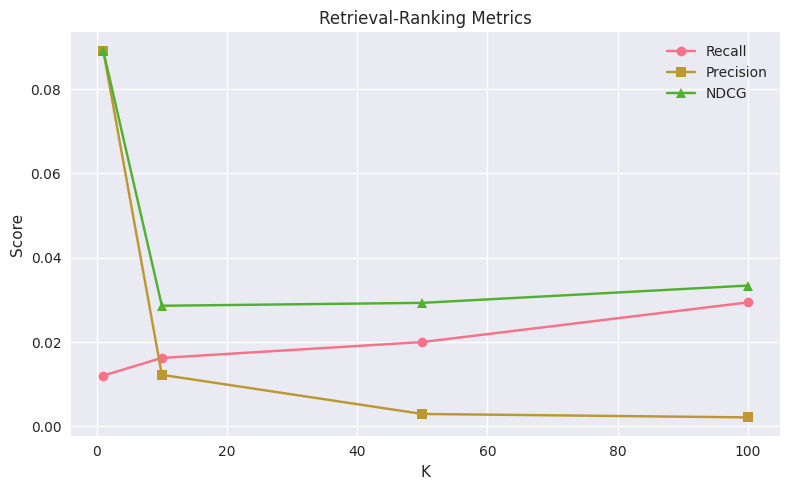

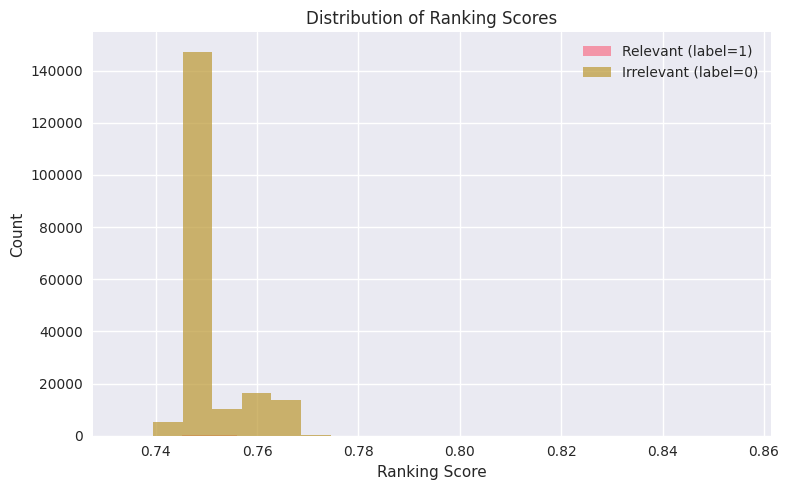


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processing user 1/2000 (user_id=AA154P)...
Processing user 101/2000 (user_id=BE445R)...
Processing user 201/2000 (user_id=CO721Q)...
Processing user 301/2000 (user_id=DW827X)...
Processing user 401/2000 (user_id=FH075V)...
Processing user 501/2000 (user_id=GP590I)...
Processing user 601/2000 (user_id=HT808K)...
Processing user 701/2000 (user_id=IY800U)...
Processing user 801/2000 (user_id=KF681V)...
Processing user 901/2000 (user_id=LS562I)...
Processing user 1001/2000 (user_id=MZ555C)...
Processing user 1101/2000 (user_id=OI133Q)...
Processing user 1201/2000 (user_id=PP105J)...
Processing user 1301/2000 (user_id=QZ701F)...
Processing user 1401/2000 (user_id=SI667R)...
Processing user 1501/2000 (user_id=TN586H)...
Processing user 1601/2000 (user_id=UZ151N)...
Processing user 1701/2000 (user_id=WH255R)...
Processing user 1801/2000 (user_id=XM629I)...
Processing 

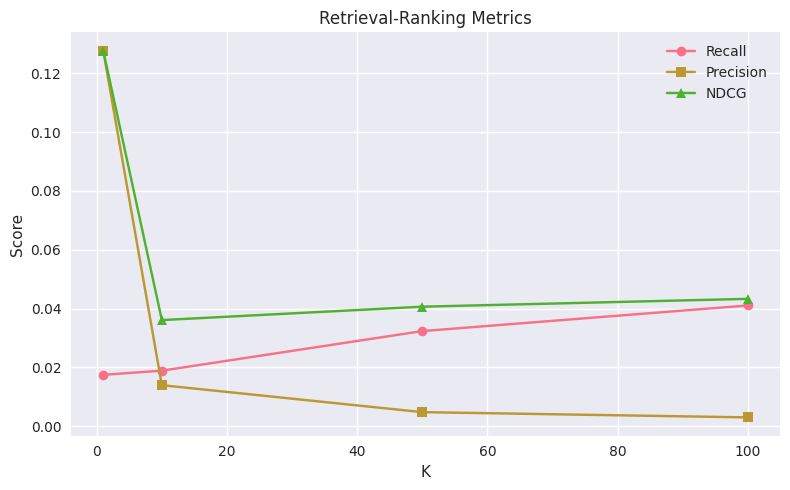

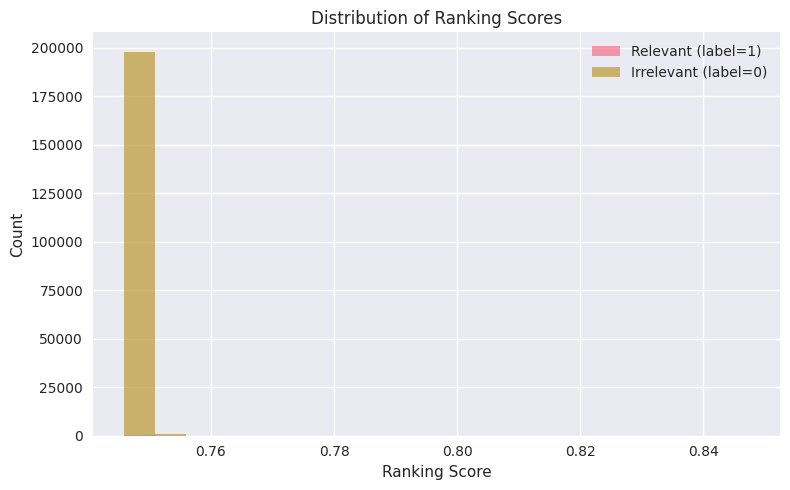


Comparison of Integrated Pipelines:
Weather Model MRR: 0.0996
No-Weather Model MRR: 0.1322
Weather features decrease MRR by 32.74%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
user_id  Recall@1  Precision@1  NDCG@1  Recall@10  Precision@10  NDCG@10  Recall@50  Precision@50  NDCG@50  Recall@100  Precision@100  NDCG@100      MRR  Average_Precision Model_Type
 AA154P  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000           0.00  0.000000 0.000000           0.000000    Weather
 AA498B  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000           0.00  0.000000 0.000000           0.000000    Weather
 AA612M  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000           0.0

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score
from catboost import Pool
import math
from datetime import datetime

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming (as in your paste.txt) ---

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/users.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/events.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/interactions.csv')

selected_users = users_df["user_id"].unique()[:2000]

events_df.rename(columns={
    'category': 'event_type',
}, inplace=True)


users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]

NO_WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'title',
    'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
    'user_interests'
]
WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'title',
    'weather_condition', 'temperature', 'precipitation', 'attendance_rate',
    'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
    'age', 'user_interests', 'user_weather_condition', 'user_temperature', 'user_precipitation'
]

print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id')
test_interactions = merged_df[merged_df["user_id"].isin(selected_users)]#.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

def prepare_ranking_features(df, feature_list, fill_defaults=None):
    df = df.copy()
    if fill_defaults is None:
        fill_defaults = {
            'user_interests': 'unknown',
            'event_type': 'unknown',
            'event_city': 'unknown',
            'user_city': 'unknown',
            'indoor_outdoor_preference': 'any',
            'weather_condition': 'unknown',
            'user_weather_condition': 'unknown',
            'interaction_distance_to_event': 0.0,
            'temperature': 20.0,
            'attendance_rate': 0.0,
            'user_temperature': 20.0,
            'user_precipitation': 0.0,
            'precipitation': 0.0,
            'age': 30,
            'event_indoor_capability': False,
            'title': 'unknown'
        }
    for feat in feature_list:
        if feat not in df.columns:
            df[feat] = fill_defaults.get(feat, 0.0)
        if df[feat].dtype == 'object':
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 'unknown'))
        elif df[feat].dtype in ['float64', 'float32']:
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 0.0))
        elif df[feat].dtype in ['int64', 'int32']:
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 0))
        elif df[feat].dtype == 'bool':
            df[feat] = df[feat].fillna(fill_defaults.get(feat, False))
    df = df[feature_list]
    return df

# --- Main retrieval-ranking pipeline with filtering, metrics, plot, CSV ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.3
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    k_values = [1, 10, 50, 100]
    ndcg_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    mrr = []
    all_scores = []
    all_labels = []
    user_metrics = []
    total_users = 0
    successful_users = 0

    user_groups = test_interactions.groupby('user_id')
    for idx, (user_id, group) in enumerate(user_groups):
        try:
            if idx % 100 == 0:
                print(f"Processing user {idx+1}/{len(user_groups)} (user_id={user_id})...")
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='left'
            )
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)
            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            y_true = [1 if eid in attended_events else 0 for eid in final_recommendation_ids]
            y_score = ranked_results['ranking_score'].values[:max_k]
            # For histogram
            all_scores.extend(list(y_score))
            all_labels.extend(list(y_true))
            # Per-user metrics for CSV
            user_metric_row = {'user_id': user_id}
            for k in k_values:
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall = hits / len(attended_events)
                precision = hits / k
                dcg = 0.0
                for idx2, eid in enumerate(final_recommendation_ids[:k]):
                    if eid in attended_events:
                        dcg += 1 / np.log2(idx2 + 2)
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(attended_events), k)))
                ndcg = dcg / idcg if idcg > 0 else 0.0
                recall_at_k[k].append(recall)
                precision_at_k[k].append(precision)
                ndcg_at_k[k].append(ndcg)
                user_metric_row[f"Recall@{k}"] = recall
                user_metric_row[f"Precision@{k}"] = precision
                user_metric_row[f"NDCG@{k}"] = ndcg
            rr = 0.0
            for idx2, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    rr = 1.0 / (idx2 + 1)
                    break
            mrr.append(rr)
            ap = average_precision_score(y_true, y_score) if sum(y_true) > 0 else 0.0
            user_metric_row["MRR"] = rr
            user_metric_row["Average_Precision"] = ap
            user_metrics.append(user_metric_row)
            successful_users += 1
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    metrics_dict = {
        "K": [],
        "Recall": [],
        "Precision": [],
        "NDCG": []
    }
    for k in k_values:
        recall = np.mean(recall_at_k[k]) if recall_at_k[k] else 0.0
        precision = np.mean(precision_at_k[k]) if precision_at_k[k] else 0.0
        ndcg = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0.0
        print(f"Recall@{k}: {recall:.4f}")
        print(f"Precision@{k}: {precision:.4f}")
        print(f"NDCG@{k}: {ndcg:.4f}")
        metrics_dict["K"].append(k)
        metrics_dict["Recall"].append(recall)
        metrics_dict["Precision"].append(precision)
        metrics_dict["NDCG"].append(ndcg)
    mrr_val = np.mean(mrr) if mrr else 0.0
    avg_precision = np.mean([row["Average_Precision"] for row in user_metrics]) if user_metrics else 0.0
    print(f"MRR: {mrr_val:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df["MRR"] = mrr_val
    metrics_df["Average_Precision"] = avg_precision
    # Visual display (metrics)
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_dict["K"], metrics_dict["Recall"], marker='o', label='Recall')
    plt.plot(metrics_dict["K"], metrics_dict["Precision"], marker='s', label='Precision')
    plt.plot(metrics_dict["K"], metrics_dict["NDCG"], marker='^', label='NDCG')
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.title("Retrieval-Ranking Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Visual display (score distribution)
    plt.figure(figsize=(8,5))
    plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=20, alpha=0.7, label='Relevant (label=1)')
    plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=20, alpha=0.7, label='Irrelevant (label=0)')
    plt.xlabel('Ranking Score')
    plt.ylabel('Count')
    plt.title('Distribution of Ranking Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()
    results_dataframe = pd.DataFrame(user_metrics)
    return {
        "mrr": mrr_val,
        "average_precision": avg_precision,
        "metrics_df": metrics_df,
        "results_dataframe": results_dataframe
    }


def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Thursday, May 29, 2025, 12:06 AM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model_Type'] = 'Weather'
    no_weather_df['Model_Type'] = 'No_Weather'
    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("weather_model_results.csv", index=False)
    no_weather_df.to_csv("no_weather_model_results.csv", index=False)
    combined_results.to_csv("combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()



## Model evaluation with semi-real-world data

In [ ]:
users_df_ = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df_ = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df_ = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(users_df_.head())

Users: 50000, Events: 10000, Interactions: 500000
Unique users: 49914
Unique events: 9999
Test interactions: 4973
Sample user_id in interactions data after conversion: ['DK924U', 'PQ743E', 'NX067Y', 'AJ787D', 'TA859C']
Sample user_id in users data after conversion: ['EJ688Y', 'RA189K', 'GM435P', 'QS920O', 'WU134L']

First 10 user IDs in interactions_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
First 10 user IDs in users_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
Number of common users: 49914
First 10 common user IDs: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
Filtered interactions with valid users: 500000
Number of common events: 9999
First 10 common event IDs: ['AA293J', 'AA319O', 'AA359E', 'AA476F', 'AA535Z', 'AA644T', 'AA704L', 'AA756J', 'AA768X', 'AA960K']
Filtered interactions with valid events: 500000
U

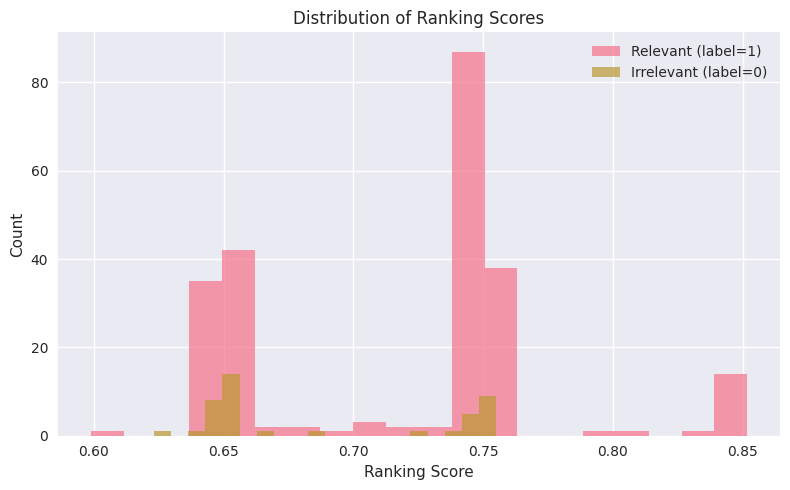


Evaluation Results:
Total users evaluated: 500
Users with successful evaluation: 223

Recall@K:
Recall@1: 0.1041
Recall@10: 0.1436
Recall@50: 0.1436
Recall@100: 0.1436

Precision@K:
Precision@1: 0.7175
Precision@10: 0.1040
Precision@50: 0.0208
Precision@100: 0.0104

NDCG@K:
NDCG@1: 0.7175
NDCG@10: 0.7450
NDCG@50: 0.7450
NDCG@100: 0.7450

MRR: 0.7399
Average Precision: 0.9091


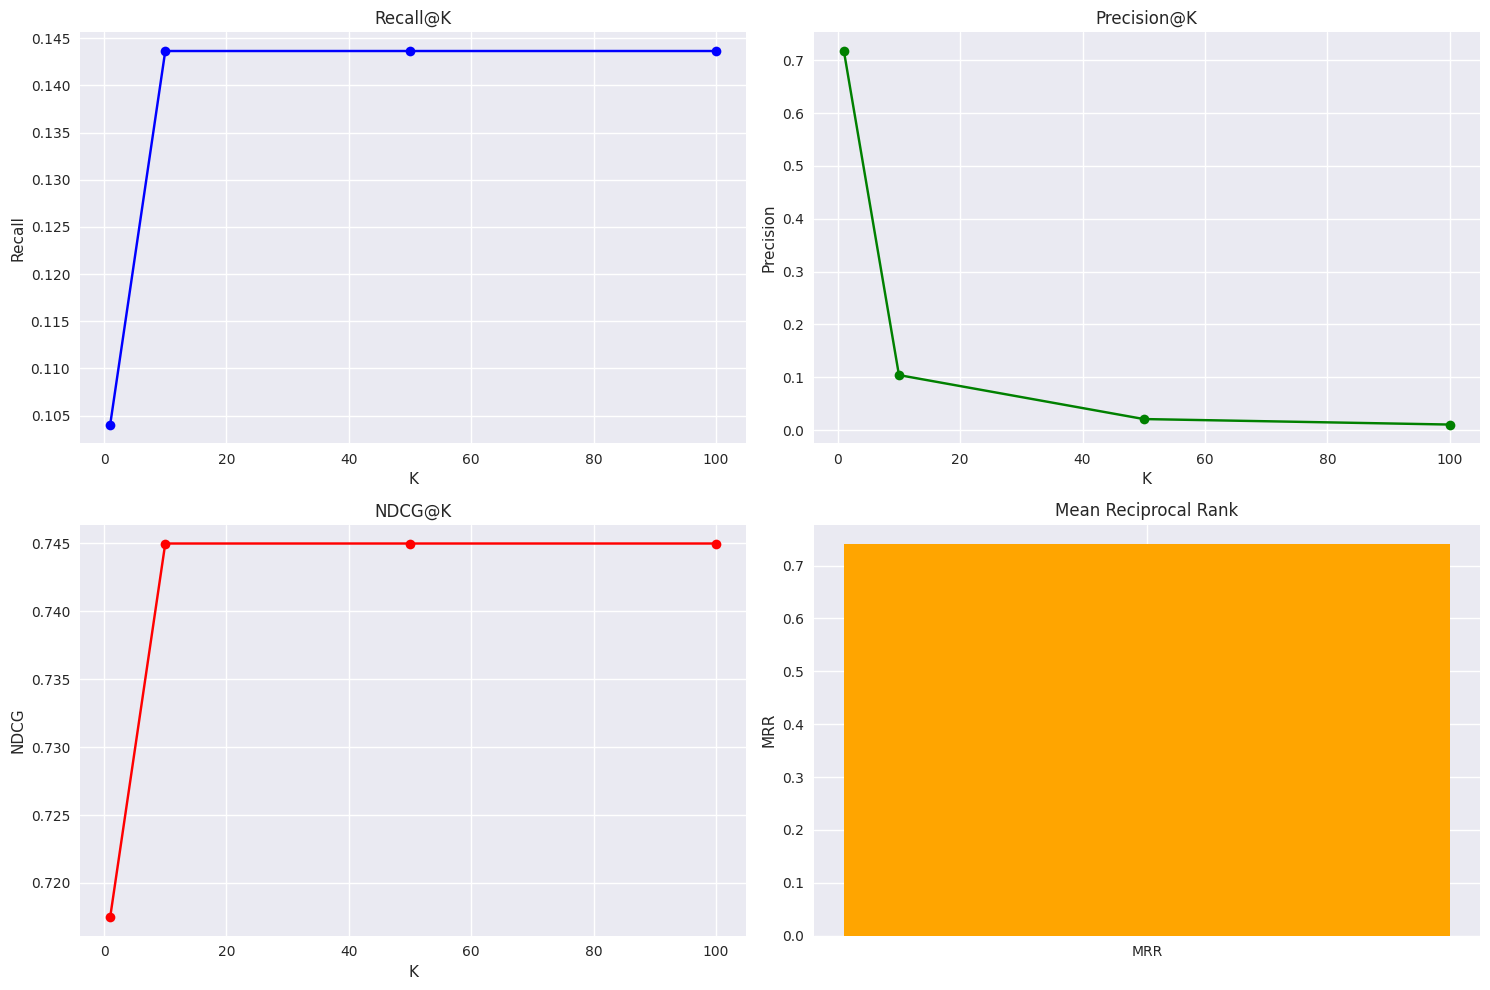

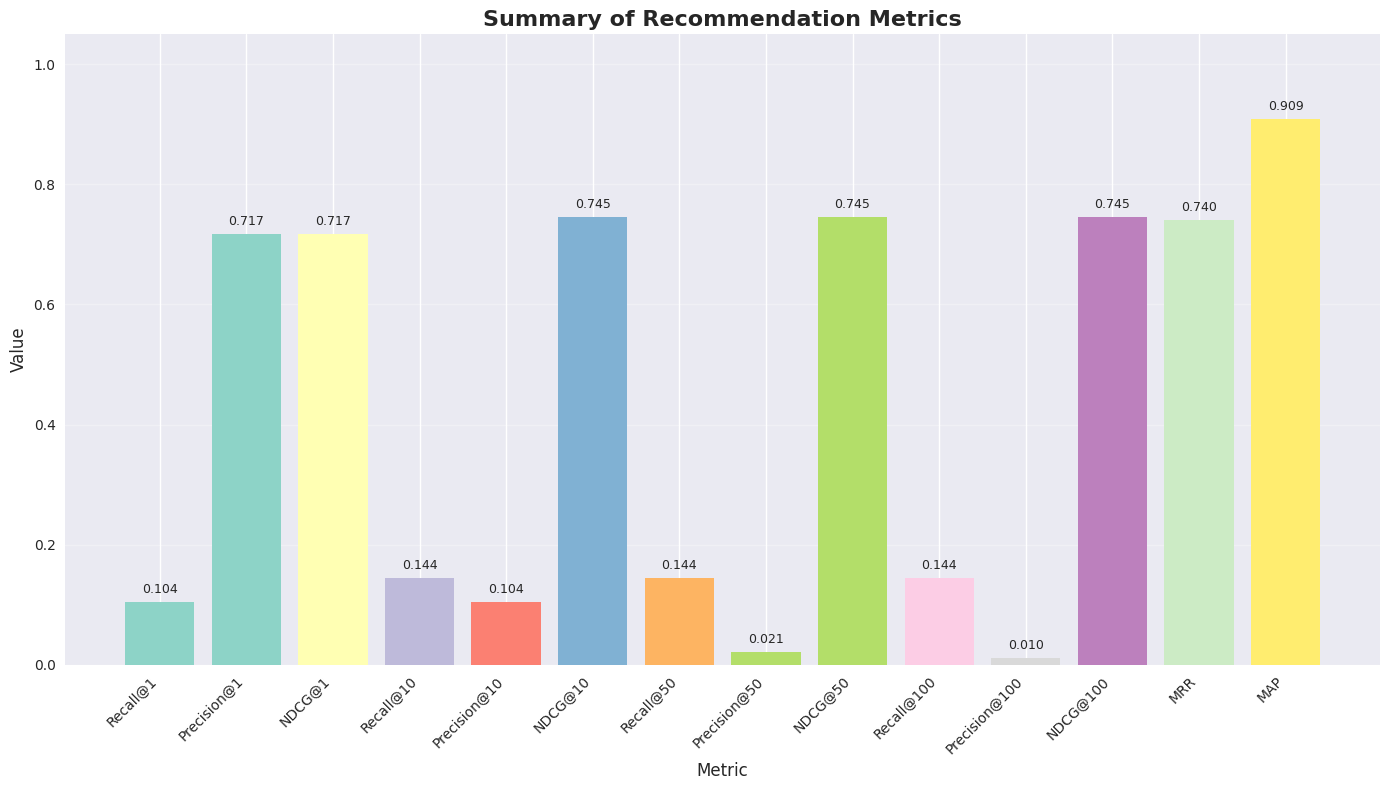


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully


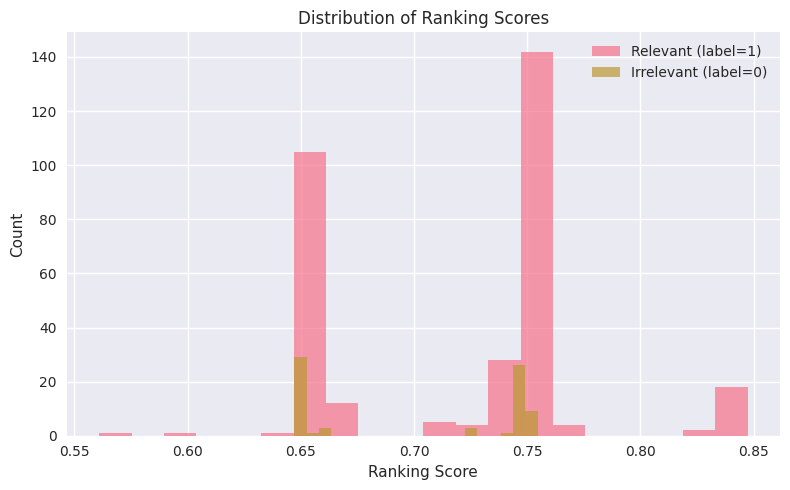


Evaluation Results:
Total users evaluated: 500
Users with successful evaluation: 300

Recall@K:
Recall@1: 0.1057
Recall@10: 0.1554
Recall@50: 0.1554
Recall@100: 0.1554

Precision@K:
Precision@1: 0.6900
Precision@10: 0.1077
Precision@50: 0.0215
Precision@100: 0.0108

NDCG@K:
NDCG@1: 0.6900
NDCG@10: 0.7375
NDCG@50: 0.7375
NDCG@100: 0.7375

MRR: 0.7283
Average Precision: 0.8495


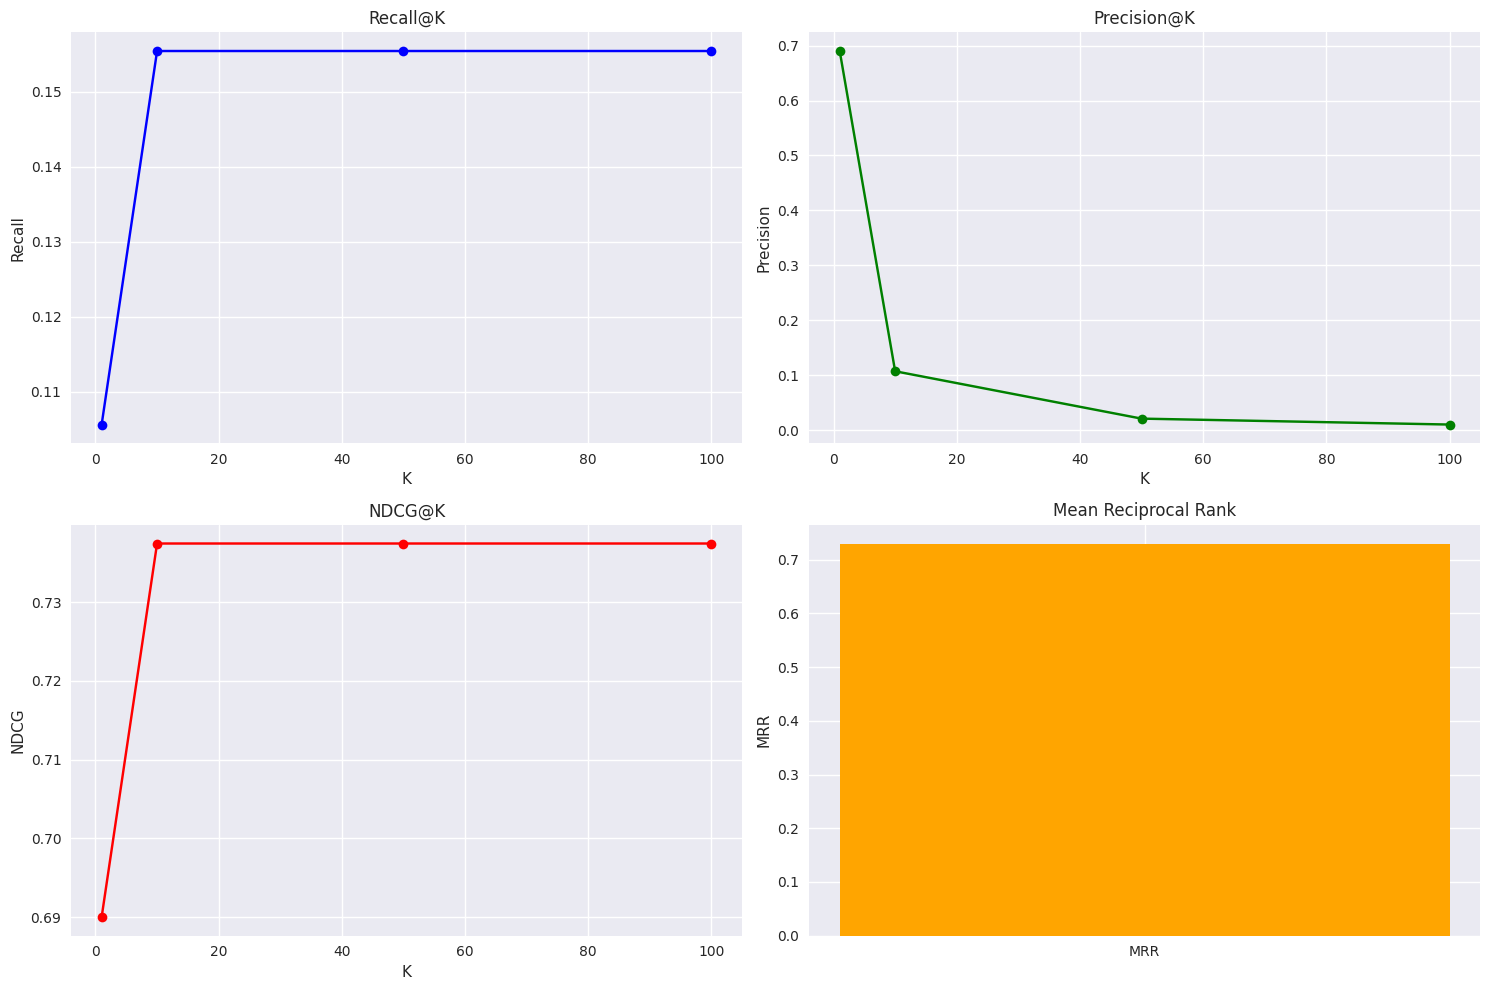

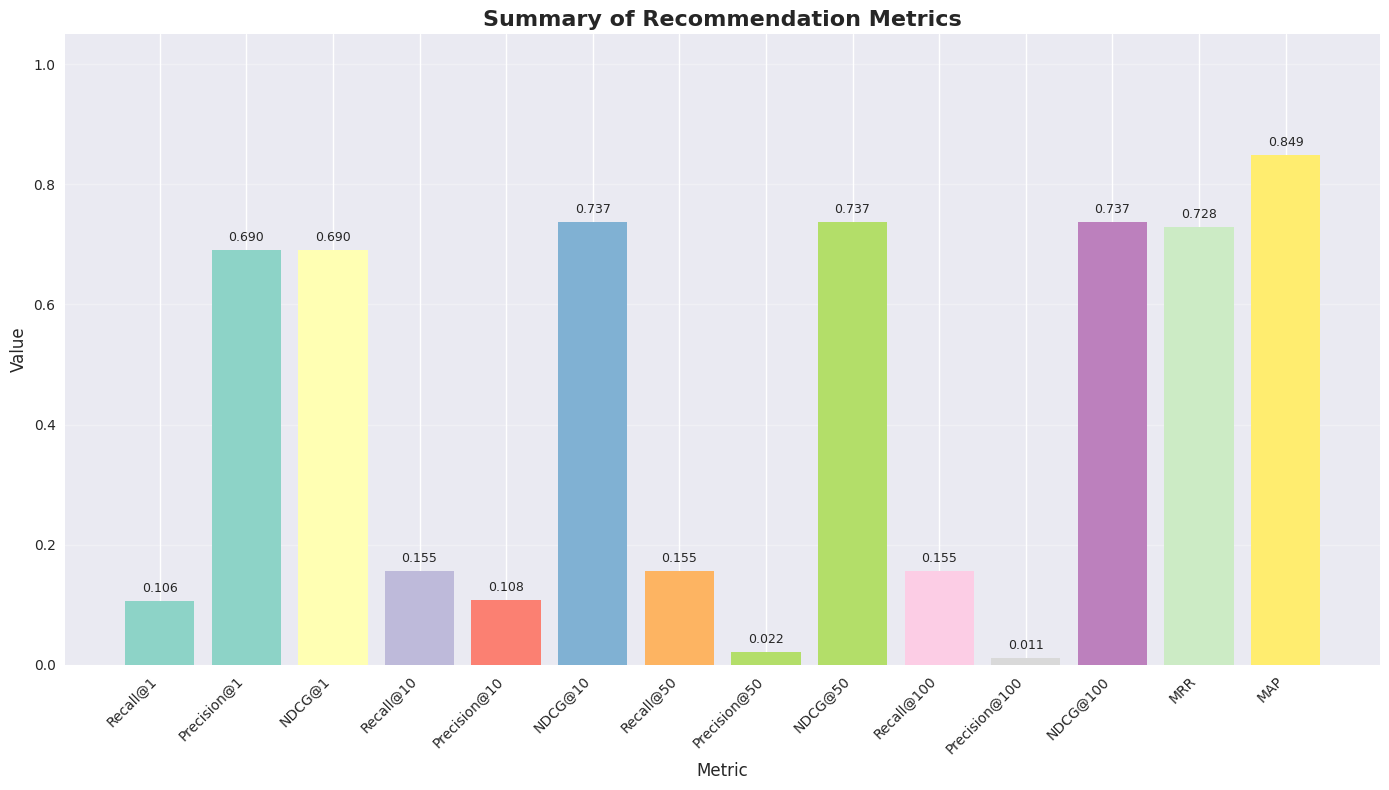


Comparison of Integrated Pipelines:
Weather Model MRR: 0.7399
No-Weather Model MRR: 0.7283
Weather features improve MRR by 1.59%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
 Recall@1  Precision@1   NDCG@1  Recall@10  Precision@10  NDCG@10  Recall@50  Precision@50  NDCG@50  Recall@100  Precision@100  NDCG@100      MRR      MAP  Total_Users  Successful_Users Model_Type
 0.104052     0.717489 0.717489   0.143640      0.104036 0.744994   0.143640      0.020807 0.744994    0.143640       0.010404  0.744994 0.739910 0.909149          500               223    Weather
 0.105660     0.690000 0.690000   0.155427      0.107667 0.737465   0.155427      0.021533 0.737465    0.155427       0.010767  0.737465 0.728333 0.849476          500               300 No_Weather


In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming (as in your paste.txt) ---
# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/users.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/events.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/interactions.csv')
events_df.rename(columns={
    'category': 'event_type',
}, inplace=True)

selected_users = users_df["user_id"].unique()[:500]
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]


print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id')
test_interactions = merged_df[merged_df["user_id"].isin(selected_users)]#.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type"]

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title', 
       'weather_condition', 'temperature','precipitation', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests','user_weather_condition', 'user_temperature',	'user_precipitation']



# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# merged_df = pd.merge(interactions_df, users_df, on='user_id')
# merged_df = pd.merge(merged_df, events_df, on='event_id') 

# # Split data for evaluation
# test_interactions = merged_df.sample(frac=1.0, random_state=42)
# print(events_df.columns)
# print(users_df.columns)
# print(interactions_df.columns)
# print(test_interactions.columns)
# print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.3
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    # Updated K values
    k_values = [1, 10, 50, 100]
    
    ndcg_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    
    user_groups = test_interactions.groupby('user_id')
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            #print(f"User embedding norm: {np.linalg.norm(user_embedding)}")
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='inner'
            )
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            # Post-retrieval filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)

            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            #ranking_features = ranking_df[feature_list]#.drop(columns=[c for c in text_cols if c in ranking_df.columns])
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype in ['float64', 'float32']:
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype in ['int64', 'int32']:
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            #print(f"User {user_id} - Final recommendations: {len(final_recommendation_ids)}")

            # Calculate metrics for each K
            for k in k_values:
                # if k > len(final_recommendation_ids):
                #     continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall_at_k[k].append(hits / len(attended_events))
                precision_at_k[k].append(hits / k)
                relevance = [1 if eid in attended_events else 0 for eid in final_recommendation_ids[:k]]
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
            
            # MRR
            mrr_score = 0
            for i, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    mrr_score = 1.0 / (i + 1)
                    break
            mrr.append(mrr_score)
            
            # For precision-recall
            for eid in attended_events:
                if eid in ranked_results['event_id'].values:
                    idx = ranked_results[ranked_results['event_id'] == eid].index[0]
                    score = ranked_results.loc[idx, 'ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    negs = [e for e in ranked_results['event_id'] if e not in attended_events][:9]
                    for neg in negs:
                        neg_idx = ranked_results[ranked_results['event_id'] == neg].index[0]
                        all_scores.append(ranked_results.loc[neg_idx, 'ranking_score'])
                        all_labels.append(0)
            successful_users += 1
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    plt.figure(figsize=(8,5))
    plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=20, alpha=0.7, label='Relevant (label=1)')
    plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=20, alpha=0.7, label='Irrelevant (label=0)')
    plt.xlabel('Ranking Score')
    plt.ylabel('Count')
    plt.title('Distribution of Ranking Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate average metrics    
    recall_at_k = {k: np.mean(vals) if vals else 0 for k, vals in recall_at_k.items()}
    precision_at_k = {k: np.mean(vals) if vals else 0 for k, vals in precision_at_k.items()}
    ndcg_at_k = {k: np.mean(vals) if vals else 0 for k, vals in ndcg_at_k.items()}
    mrr_avg = np.mean(mrr) if mrr else 0
    
    print("\nEvaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    print("\nRecall@K:")
    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.4f}")
    print("\nPrecision@K:")
    for k, v in precision_at_k.items():
        print(f"Precision@{k}: {v:.4f}")
    print("\nNDCG@K:")
    for k, v in ndcg_at_k.items():
        print(f"NDCG@{k}: {v:.4f}")
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate MAP
    if all_scores:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
    else:
        ap = None
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o', color='blue')
    axes[0, 0].set_title('Recall@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(list(precision_at_k.keys()), list(precision_at_k.values()), marker='o', color='green')
    axes[0, 1].set_title('Precision@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(list(ndcg_at_k.keys()), list(ndcg_at_k.values()), marker='o', color='red')
    axes[1, 0].set_title('NDCG@K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('NDCG')
    axes[1, 0].grid(True)
    
    axes[1, 1].bar(['MRR'], [mrr_avg], color='orange')
    axes[1, 1].set_title('Mean Reciprocal Rank')
    axes[1, 1].set_ylabel('MRR')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()

    # Create summary bar plot with matplotlib and different colors
    metrics = []
    values = []
    colors = []
    
    # Define color palette
    color_palette = plt.cm.Set3(np.linspace(0, 1, 15))  # Generate 15 distinct colors
    color_idx = 0
    
    # Add metrics for each K
    for k in k_values:
        metrics.append(f"Recall@{k}")
        values.append(recall_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"Precision@{k}")
        values.append(precision_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"NDCG@{k}")
        values.append(ndcg_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1

    # Add MRR and MAP
    metrics.append("MRR")
    values.append(mrr_avg)
    colors.append(color_palette[color_idx])
    color_idx += 1
    
    if ap is not None:
        metrics.append("MAP")
        values.append(ap)
        colors.append(color_palette[color_idx])

    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(metrics, values, color=colors)
    plt.title('Summary of Recommendation Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('summary_metrics_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create and return results dataframe
    results_dict = {}
    
    # Add metrics for each K
    for k in k_values:
        results_dict[f'Recall@{k}'] = [recall_at_k[k]]
        results_dict[f'Precision@{k}'] = [precision_at_k[k]]
        results_dict[f'NDCG@{k}'] = [ndcg_at_k[k]]
    
    # Add other metrics
    results_dict['MRR'] = [mrr_avg]
    if ap is not None:
        results_dict['MAP'] = [ap]
    results_dict['Total_Users'] = [total_users]
    results_dict['Successful_Users'] = [successful_users]
    
    results_df = pd.DataFrame(results_dict)

    return {
        "results_dataframe": results_df,
        "recall_at_k": recall_at_k,
        "precision_at_k": precision_at_k,
        "ndcg_at_k": ndcg_at_k,
        "mrr": mrr_avg,
        "average_precision": ap,
        "total_users": total_users,
        "successful_users": successful_users
    }


def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model_Type'] = 'Weather'
    no_weather_df['Model_Type'] = 'No_Weather'
    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("weather_model_results.csv", index=False)
    no_weather_df.to_csv("no_weather_model_results.csv", index=False)
    combined_results.to_csv("combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()

Unnamed: 0                 0
user_id                    0
event_id                   0
interaction_type           0
distance_to_event          0
interaction_label          0
event_weather_condition    0
event_temperature          0
event_precipitation_sum    0
user_weather_condition     0
user_temperature           0
user_precipitation         0
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common 

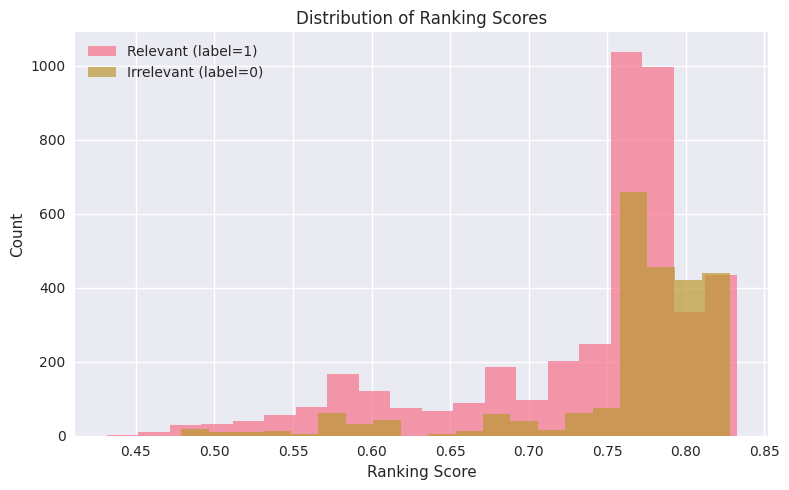


Evaluation Results:
Total users evaluated: 5315
Users with successful evaluation: 1333

Recall@K:
Recall@1: 0.4180
Recall@10: 0.1337
Recall@50: 0.1494
Recall@100: 0.0000

Precision@K:
Precision@1: 0.9625
Precision@10: 0.9434
Precision@50: 0.9600
Precision@100: 0.0000

NDCG@K:
NDCG@1: 0.9625
NDCG@10: 0.9739
NDCG@50: 0.9911
NDCG@100: 0.0000

MRR: 0.9690
Average Precision: 0.6034


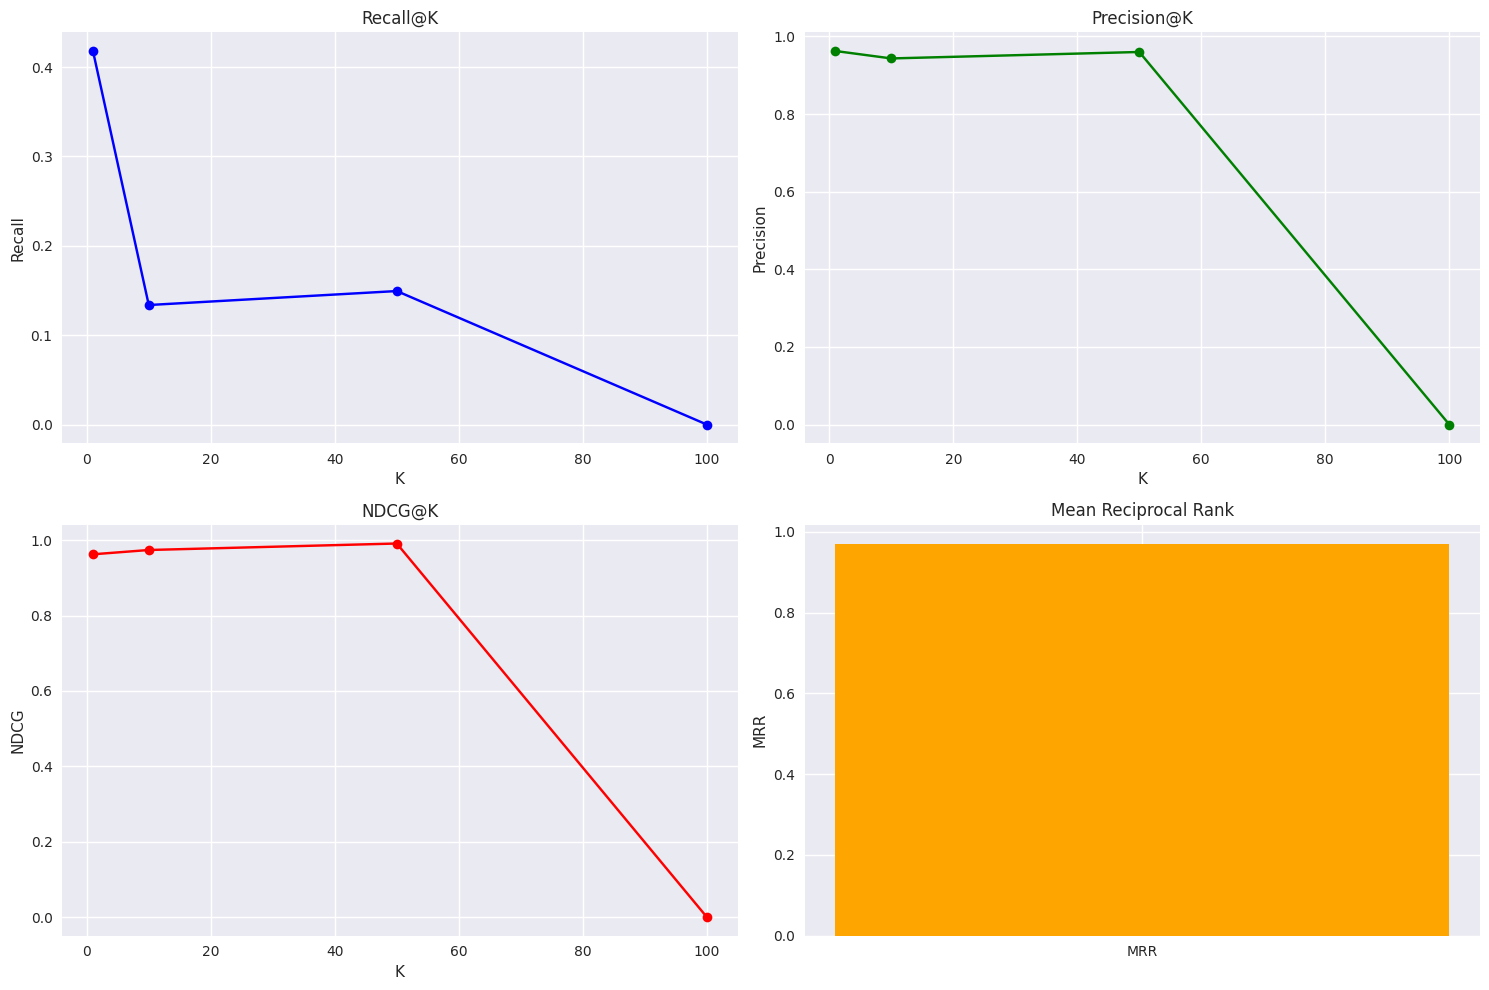

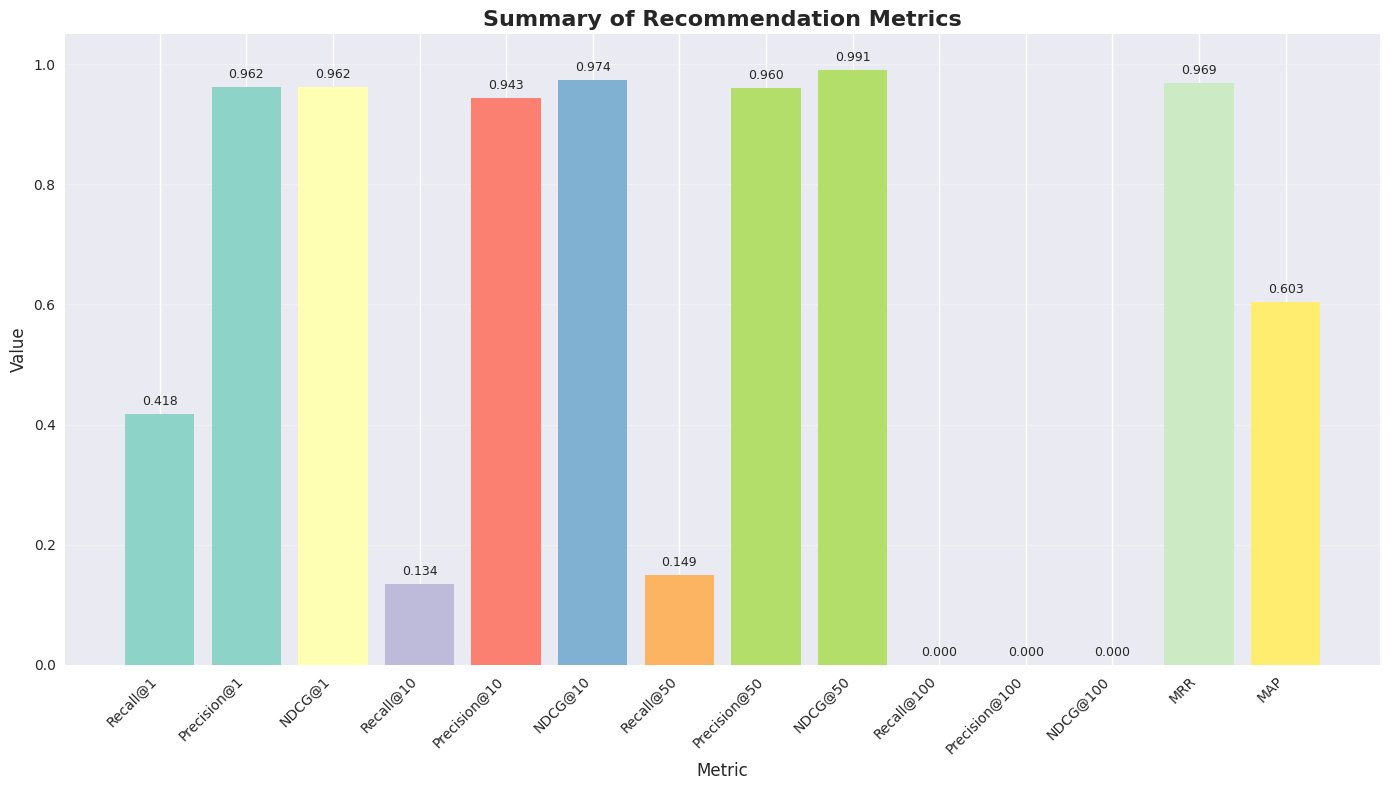


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully


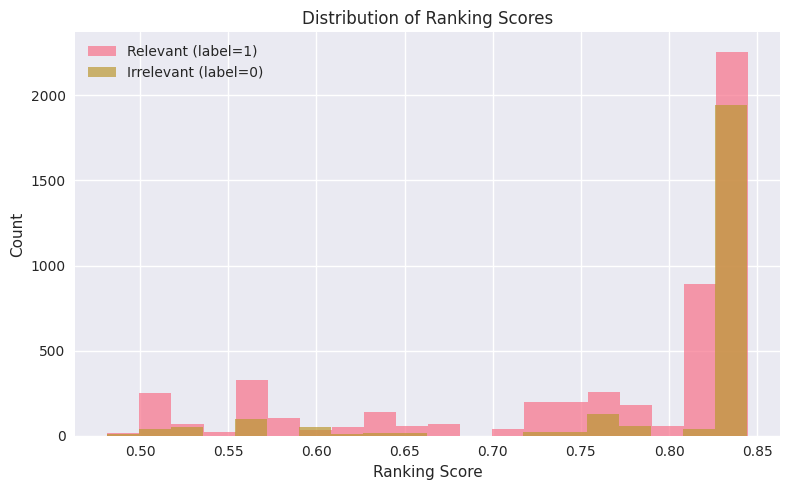


Evaluation Results:
Total users evaluated: 5315
Users with successful evaluation: 1931

Recall@K:
Recall@1: 0.4443
Recall@10: 0.1345
Recall@50: 0.1505
Recall@100: 0.0000

Precision@K:
Precision@1: 0.9606
Precision@10: 0.9421
Precision@50: 0.9689
Precision@100: 0.0000

NDCG@K:
NDCG@1: 0.9606
NDCG@10: 0.9724
NDCG@50: 0.9912
NDCG@100: 0.0000

MRR: 0.9677
Average Precision: 0.5846


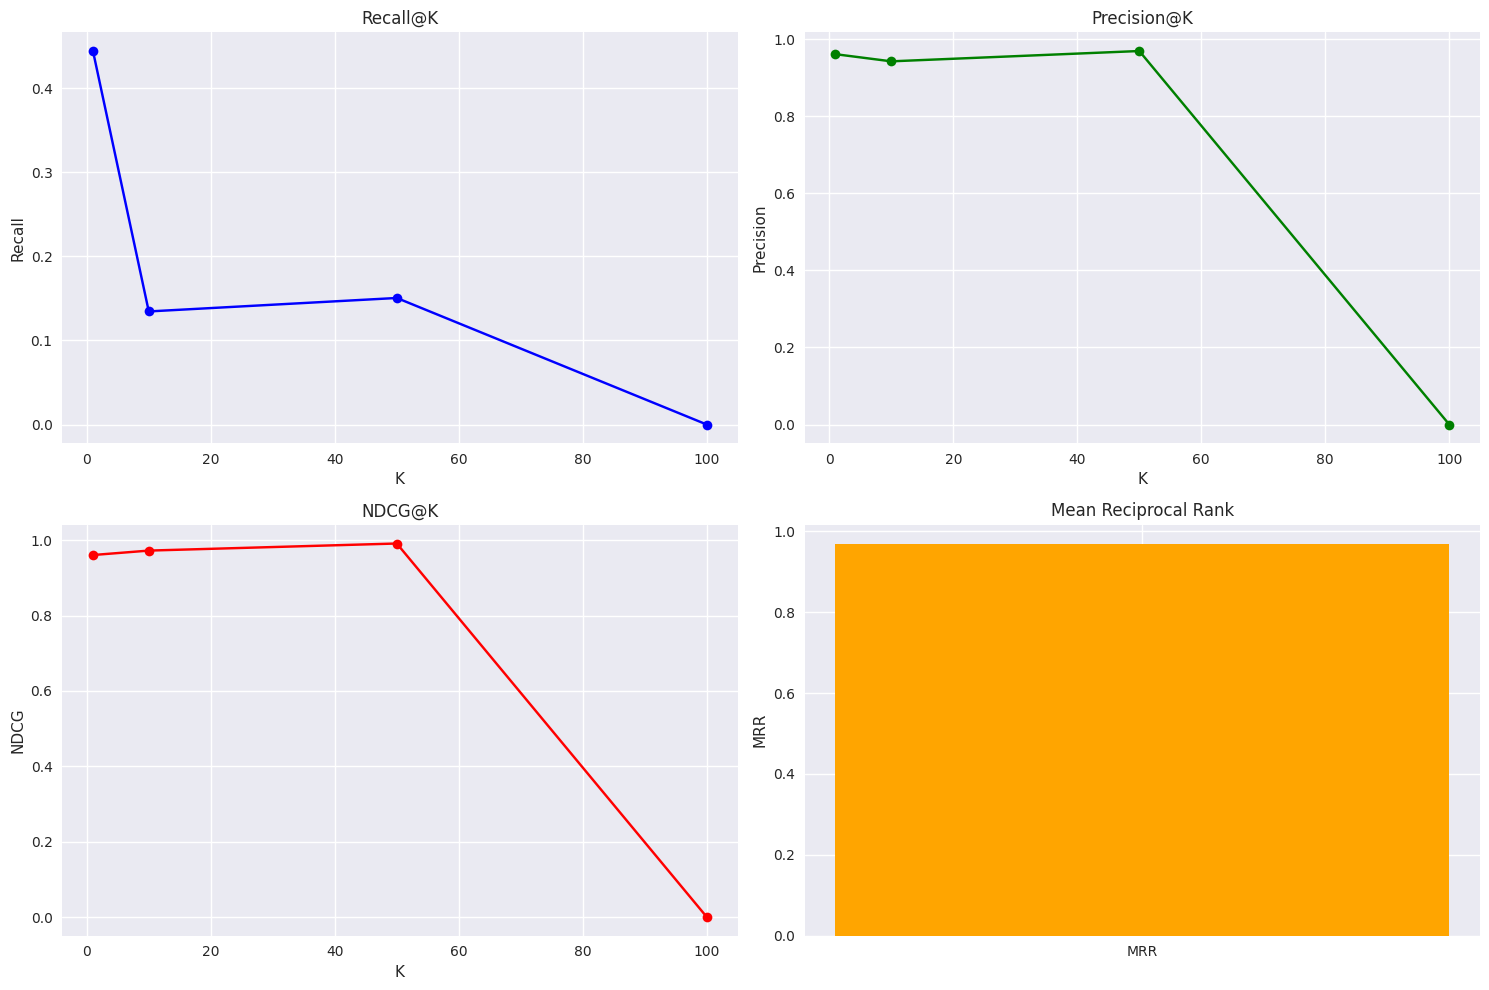

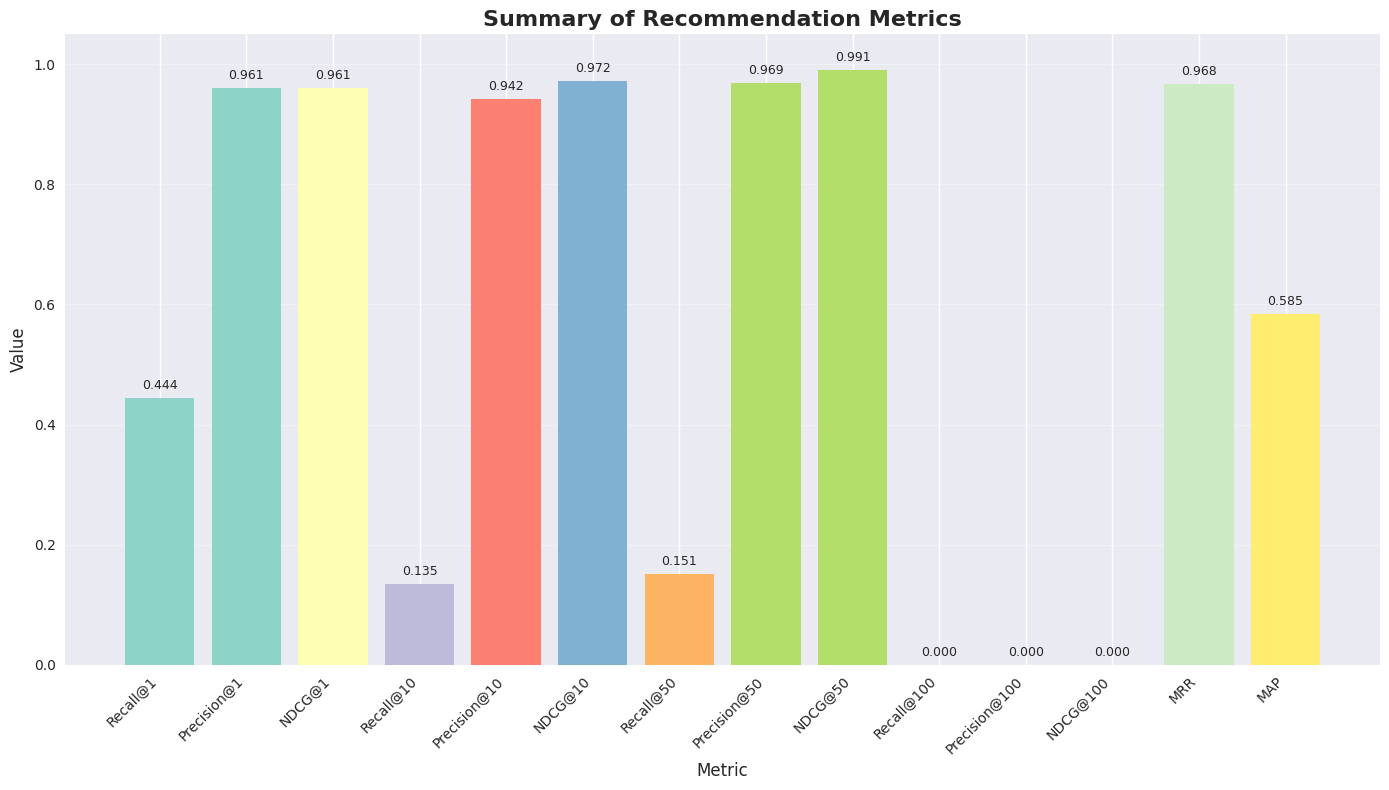


Comparison of Integrated Pipelines:
Weather Model MRR: 0.9690
No-Weather Model MRR: 0.9677
Weather features improve MRR by 0.14%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
 Recall@1  Precision@1   NDCG@1  Recall@10  Precision@10  NDCG@10  Recall@50  Precision@50  NDCG@50  Recall@100  Precision@100  NDCG@100      MRR     MAP  Total_Users  Successful_Users Model_Type
 0.417999     0.962491 0.962491   0.133749      0.943363 0.973899   0.149393      0.960000 0.991113           0              0         0 0.969017 0.60345         5315              1333    Weather
 0.444286     0.960642 0.960642   0.134527      0.942105 0.972408   0.150548      0.968889 0.991204           0              0         0 0.967672 0.58460         5315              1931 No_Weather


In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming (as in your paste.txt) ---

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'joinedAt': 'signup_date',

}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type"]

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title', 
       'weather_condition', 'temperature','precipitation', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests','user_weather_condition', 'user_temperature',	'user_precipitation']



# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id') 

# Split data for evaluation
test_interactions = merged_df.sample(frac=1.0, random_state=42)
print(events_df.columns)
print(users_df.columns)
print(interactions_df.columns)
print(test_interactions.columns)
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.3
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    # Updated K values
    k_values = [1, 10, 50, 100]
    
    ndcg_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    
    user_groups = test_interactions.groupby('user_id')
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='inner'
            )
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            # Post-retrieval filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)

            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            #ranking_features = ranking_df[feature_list]#.drop(columns=[c for c in text_cols if c in ranking_df.columns])
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype in ['float64', 'float32']:
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype in ['int64', 'int32']:
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            
            # Calculate metrics for each K
            for k in k_values:
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall_at_k[k].append(hits / len(attended_events))
                precision_at_k[k].append(hits / k)
                relevance = [1 if eid in attended_events else 0 for eid in final_recommendation_ids[:k]]
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
            
            # MRR
            mrr_score = 0
            for i, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    mrr_score = 1.0 / (i + 1)
                    break
            mrr.append(mrr_score)
            
            # For precision-recall
            for eid in attended_events:
                if eid in ranked_results['event_id'].values:
                    idx = ranked_results[ranked_results['event_id'] == eid].index[0]
                    score = ranked_results.loc[idx, 'ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    negs = [e for e in ranked_results['event_id'] if e not in attended_events][:9]
                    for neg in negs:
                        neg_idx = ranked_results[ranked_results['event_id'] == neg].index[0]
                        all_scores.append(ranked_results.loc[neg_idx, 'ranking_score'])
                        all_labels.append(0)
            successful_users += 1
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    plt.figure(figsize=(8,5))
    plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=20, alpha=0.7, label='Relevant (label=1)')
    plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=20, alpha=0.7, label='Irrelevant (label=0)')
    plt.xlabel('Ranking Score')
    plt.ylabel('Count')
    plt.title('Distribution of Ranking Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate average metrics    
    recall_at_k = {k: np.mean(vals) if vals else 0 for k, vals in recall_at_k.items()}
    precision_at_k = {k: np.mean(vals) if vals else 0 for k, vals in precision_at_k.items()}
    ndcg_at_k = {k: np.mean(vals) if vals else 0 for k, vals in ndcg_at_k.items()}
    mrr_avg = np.mean(mrr) if mrr else 0
    
    print("\nEvaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    print("\nRecall@K:")
    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.4f}")
    print("\nPrecision@K:")
    for k, v in precision_at_k.items():
        print(f"Precision@{k}: {v:.4f}")
    print("\nNDCG@K:")
    for k, v in ndcg_at_k.items():
        print(f"NDCG@{k}: {v:.4f}")
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate MAP
    if all_scores:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
    else:
        ap = None
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o', color='blue')
    axes[0, 0].set_title('Recall@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(list(precision_at_k.keys()), list(precision_at_k.values()), marker='o', color='green')
    axes[0, 1].set_title('Precision@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(list(ndcg_at_k.keys()), list(ndcg_at_k.values()), marker='o', color='red')
    axes[1, 0].set_title('NDCG@K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('NDCG')
    axes[1, 0].grid(True)
    
    axes[1, 1].bar(['MRR'], [mrr_avg], color='orange')
    axes[1, 1].set_title('Mean Reciprocal Rank')
    axes[1, 1].set_ylabel('MRR')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()

    # Create summary bar plot with matplotlib and different colors
    metrics = []
    values = []
    colors = []
    
    # Define color palette
    color_palette = plt.cm.Set3(np.linspace(0, 1, 15))  # Generate 15 distinct colors
    color_idx = 0
    
    # Add metrics for each K
    for k in k_values:
        metrics.append(f"Recall@{k}")
        values.append(recall_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"Precision@{k}")
        values.append(precision_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"NDCG@{k}")
        values.append(ndcg_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1

    # Add MRR and MAP
    metrics.append("MRR")
    values.append(mrr_avg)
    colors.append(color_palette[color_idx])
    color_idx += 1
    
    if ap is not None:
        metrics.append("MAP")
        values.append(ap)
        colors.append(color_palette[color_idx])

    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(metrics, values, color=colors)
    plt.title('Summary of Recommendation Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('summary_metrics_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create and return results dataframe
    results_dict = {}
    
    # Add metrics for each K
    for k in k_values:
        results_dict[f'Recall@{k}'] = [recall_at_k[k]]
        results_dict[f'Precision@{k}'] = [precision_at_k[k]]
        results_dict[f'NDCG@{k}'] = [ndcg_at_k[k]]
    
    # Add other metrics
    results_dict['MRR'] = [mrr_avg]
    if ap is not None:
        results_dict['MAP'] = [ap]
    results_dict['Total_Users'] = [total_users]
    results_dict['Successful_Users'] = [successful_users]
    
    results_df = pd.DataFrame(results_dict)

    return {
        "results_dataframe": results_df,
        "recall_at_k": recall_at_k,
        "precision_at_k": precision_at_k,
        "ndcg_at_k": ndcg_at_k,
        "mrr": mrr_avg,
        "average_precision": ap,
        "total_users": total_users,
        "successful_users": successful_users
    }


def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model_Type'] = 'Weather'
    no_weather_df['Model_Type'] = 'No_Weather'
    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("weather_model_results.csv", index=False)
    no_weather_df.to_csv("no_weather_model_results.csv", index=False)
    combined_results.to_csv("combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()

In [24]:
weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
print(weather_model.get_feature_names_())
print(no_weather_model.get_feature_names_())

AttributeError: 'CatBoostClassifier' object has no attribute 'get_feature_names_'

Users: 5315, Events: 4967, Interactions: 28249
Unique users: 5315
Unique events: 4967
Test interactions: 28249
Starting evaluation pipeline for retrieval and ranking models...
Current date: Thursday, May 29, 2025, 12:06 AM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Total users evaluated: 5315
Users with successful evaluation: 5120
Recall@1: 0.0863
Precision@1: 0.2125
NDCG@1: 0.2125
Recall@10: 0.0997
Precision@10: 0.0518
NDCG@10: 0.1414
Recall@50: 0.1098
Precision@50: 0.0152
NDCG@50: 0.1317
Recall@100: 0.1144
Precision@100: 0.0080
NDCG@100: 0.1303
MRR: 0.2148
Average Precision: 0.2132


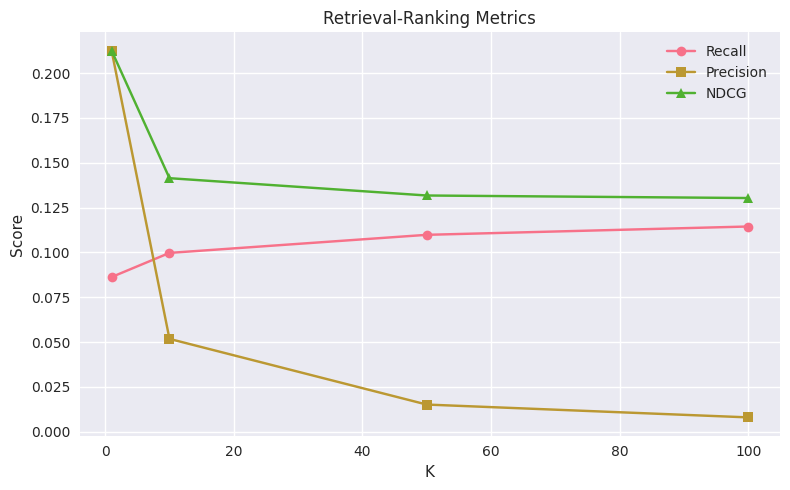


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Total users evaluated: 5315
Users with successful evaluation: 5120
Recall@1: 0.1285
Precision@1: 0.2988
NDCG@1: 0.2988
Recall@10: 0.1513
Precision@10: 0.0654
NDCG@10: 0.2004
Recall@50: 0.1537
Precision@50: 0.0173
NDCG@50: 0.1848
Recall@100: 0.1540
Precision@100: 0.0089
NDCG@100: 0.1821
MRR: 0.3018
Average Precision: 0.2993


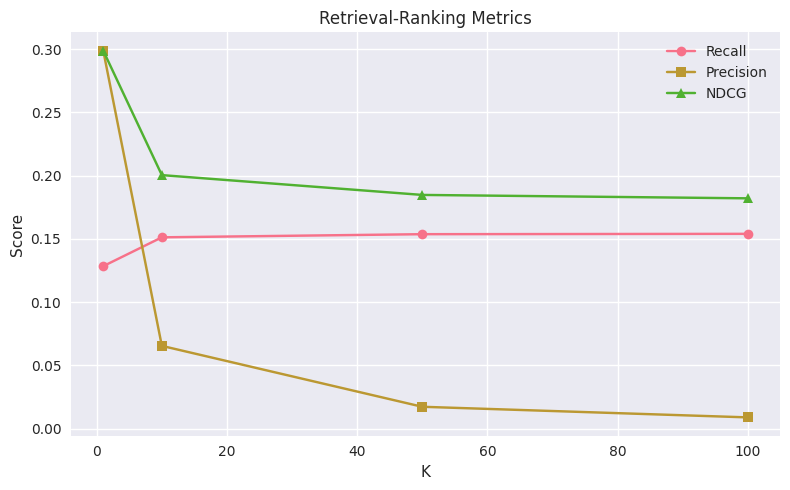


Comparison of Integrated Pipelines:
Weather Model MRR: 0.2148
No-Weather Model MRR: 0.3018
Weather features decrease MRR by 40.54%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
   user_id  Recall@1  Precision@1  NDCG@1  Recall@10  Precision@10  NDCG@10  Recall@50  Precision@50  NDCG@50  Recall@100  Precision@100  NDCG@100      MRR  Average_Precision Model_Type
1000957666  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000           0.00  0.000000 0.000000           0.000000    Weather
1002026815  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000           0.00  0.000000 0.000000           0.000000    Weather
1002319016  0.000000          0.0     0.0   0.000000           0.0 0.000000   0.000000          0.00 0.000000    0.000000  

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score
from catboost import Pool
import math
from datetime import datetime

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming (as in your paste.txt) ---

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'joinedAt': 'signup_date',
}, inplace=True)
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]

NO_WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'title',
    'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
    'user_interests'
]
WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'title',
    'weather_condition', 'temperature', 'precipitation', 'attendance_rate',
    'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
    'age', 'user_interests', 'user_weather_condition', 'user_temperature', 'user_precipitation'
]

print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id')
test_interactions = merged_df.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

def prepare_ranking_features(df, feature_list, fill_defaults=None):
    df = df.copy()
    if fill_defaults is None:
        fill_defaults = {
            'user_interests': 'unknown',
            'event_type': 'unknown',
            'event_city': 'unknown',
            'user_city': 'unknown',
            'indoor_outdoor_preference': 'any',
            'weather_condition': 'unknown',
            'user_weather_condition': 'unknown',
            'interaction_distance_to_event': 0.0,
            'temperature': 20.0,
            'attendance_rate': 0.0,
            'user_temperature': 20.0,
            'user_precipitation': 0.0,
            'precipitation': 0.0,
            'age': 30,
            'event_indoor_capability': False,
            'title': 'unknown'
        }
    for feat in feature_list:
        if feat not in df.columns:
            df[feat] = fill_defaults.get(feat, 0.0)
        if df[feat].dtype == 'object':
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 'unknown'))
        elif df[feat].dtype in ['float64', 'float32']:
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 0.0))
        elif df[feat].dtype in ['int64', 'int32']:
            df[feat] = df[feat].fillna(fill_defaults.get(feat, 0))
        elif df[feat].dtype == 'bool':
            df[feat] = df[feat].fillna(fill_defaults.get(feat, False))
    df = df[feature_list]
    return df

# --- Main retrieval-ranking pipeline with filtering, metrics, plot, CSV ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.3
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    k_values = [1, 10, 50, 100]
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    ndcg_at_k = {k: [] for k in k_values}
    mrr_list = []
    ap_list = []
    user_metrics = []

    total_users = 0
    successful_users = 0

    user_groups = test_interactions.groupby('user_id')
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='left'
            )
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)
            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            y_true = [1 if eid in attended_events else 0 for eid in final_recommendation_ids]
            y_score = ranked_results['ranking_score'].values[:max_k]
            # Per-user metrics for CSV
            user_metric_row = {'user_id': user_id}
            for k in k_values:
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall = hits / len(attended_events)
                precision = hits / k
                dcg = 0.0
                for idx, eid in enumerate(final_recommendation_ids[:k]):
                    if eid in attended_events:
                        dcg += 1 / np.log2(idx + 2)
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(attended_events), k)))
                ndcg = dcg / idcg if idcg > 0 else 0.0
                recall_at_k[k].append(recall)
                precision_at_k[k].append(precision)
                ndcg_at_k[k].append(ndcg)
                user_metric_row[f"Recall@{k}"] = recall
                user_metric_row[f"Precision@{k}"] = precision
                user_metric_row[f"NDCG@{k}"] = ndcg
            rr = 0.0
            for idx, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    rr = 1.0 / (idx + 1)
                    break
            mrr_list.append(rr)
            ap = average_precision_score(y_true, y_score) if sum(y_true) > 0 else 0.0
            ap_list.append(ap)
            user_metric_row["MRR"] = rr
            user_metric_row["Average_Precision"] = ap
            user_metrics.append(user_metric_row)
            successful_users += 1
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    metrics_dict = {
        "K": [],
        "Recall": [],
        "Precision": [],
        "NDCG": []
    }
    for k in k_values:
        recall = np.mean(recall_at_k[k]) if recall_at_k[k] else 0.0
        precision = np.mean(precision_at_k[k]) if precision_at_k[k] else 0.0
        ndcg = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0.0
        print(f"Recall@{k}: {recall:.4f}")
        print(f"Precision@{k}: {precision:.4f}")
        print(f"NDCG@{k}: {ndcg:.4f}")
        metrics_dict["K"].append(k)
        metrics_dict["Recall"].append(recall)
        metrics_dict["Precision"].append(precision)
        metrics_dict["NDCG"].append(ndcg)
    mrr = np.mean(mrr_list) if mrr_list else 0.0
    avg_precision = np.mean(ap_list) if ap_list else 0.0
    print(f"MRR: {mrr:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df["MRR"] = mrr
    metrics_df["Average_Precision"] = avg_precision
    # Visual display
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_dict["K"], metrics_dict["Recall"], marker='o', label='Recall')
    plt.plot(metrics_dict["K"], metrics_dict["Precision"], marker='s', label='Precision')
    plt.plot(metrics_dict["K"], metrics_dict["NDCG"], marker='^', label='NDCG')
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.title("Retrieval-Ranking Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Per-user results DataFrame
    results_dataframe = pd.DataFrame(user_metrics)
    return {
        "mrr": mrr,
        "average_precision": avg_precision,
        "metrics_df": metrics_df,
        "results_dataframe": results_dataframe
    }

def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Thursday, May 29, 2025, 12:06 AM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model_Type'] = 'Weather'
    no_weather_df['Model_Type'] = 'No_Weather'
    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("weather_model_results.csv", index=False)
    no_weather_df.to_csv("no_weather_model_results.csv", index=False)
    combined_results.to_csv("combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()



## updated relevance logic to include attended and interest match

Unnamed: 0                 0
user_id                    0
event_id                   0
interaction_type           0
distance_to_event          0
interaction_label          0
event_weather_condition    0
event_temperature          0
event_precipitation_sum    0
user_weather_condition     0
user_temperature           0
user_precipitation         0
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common 

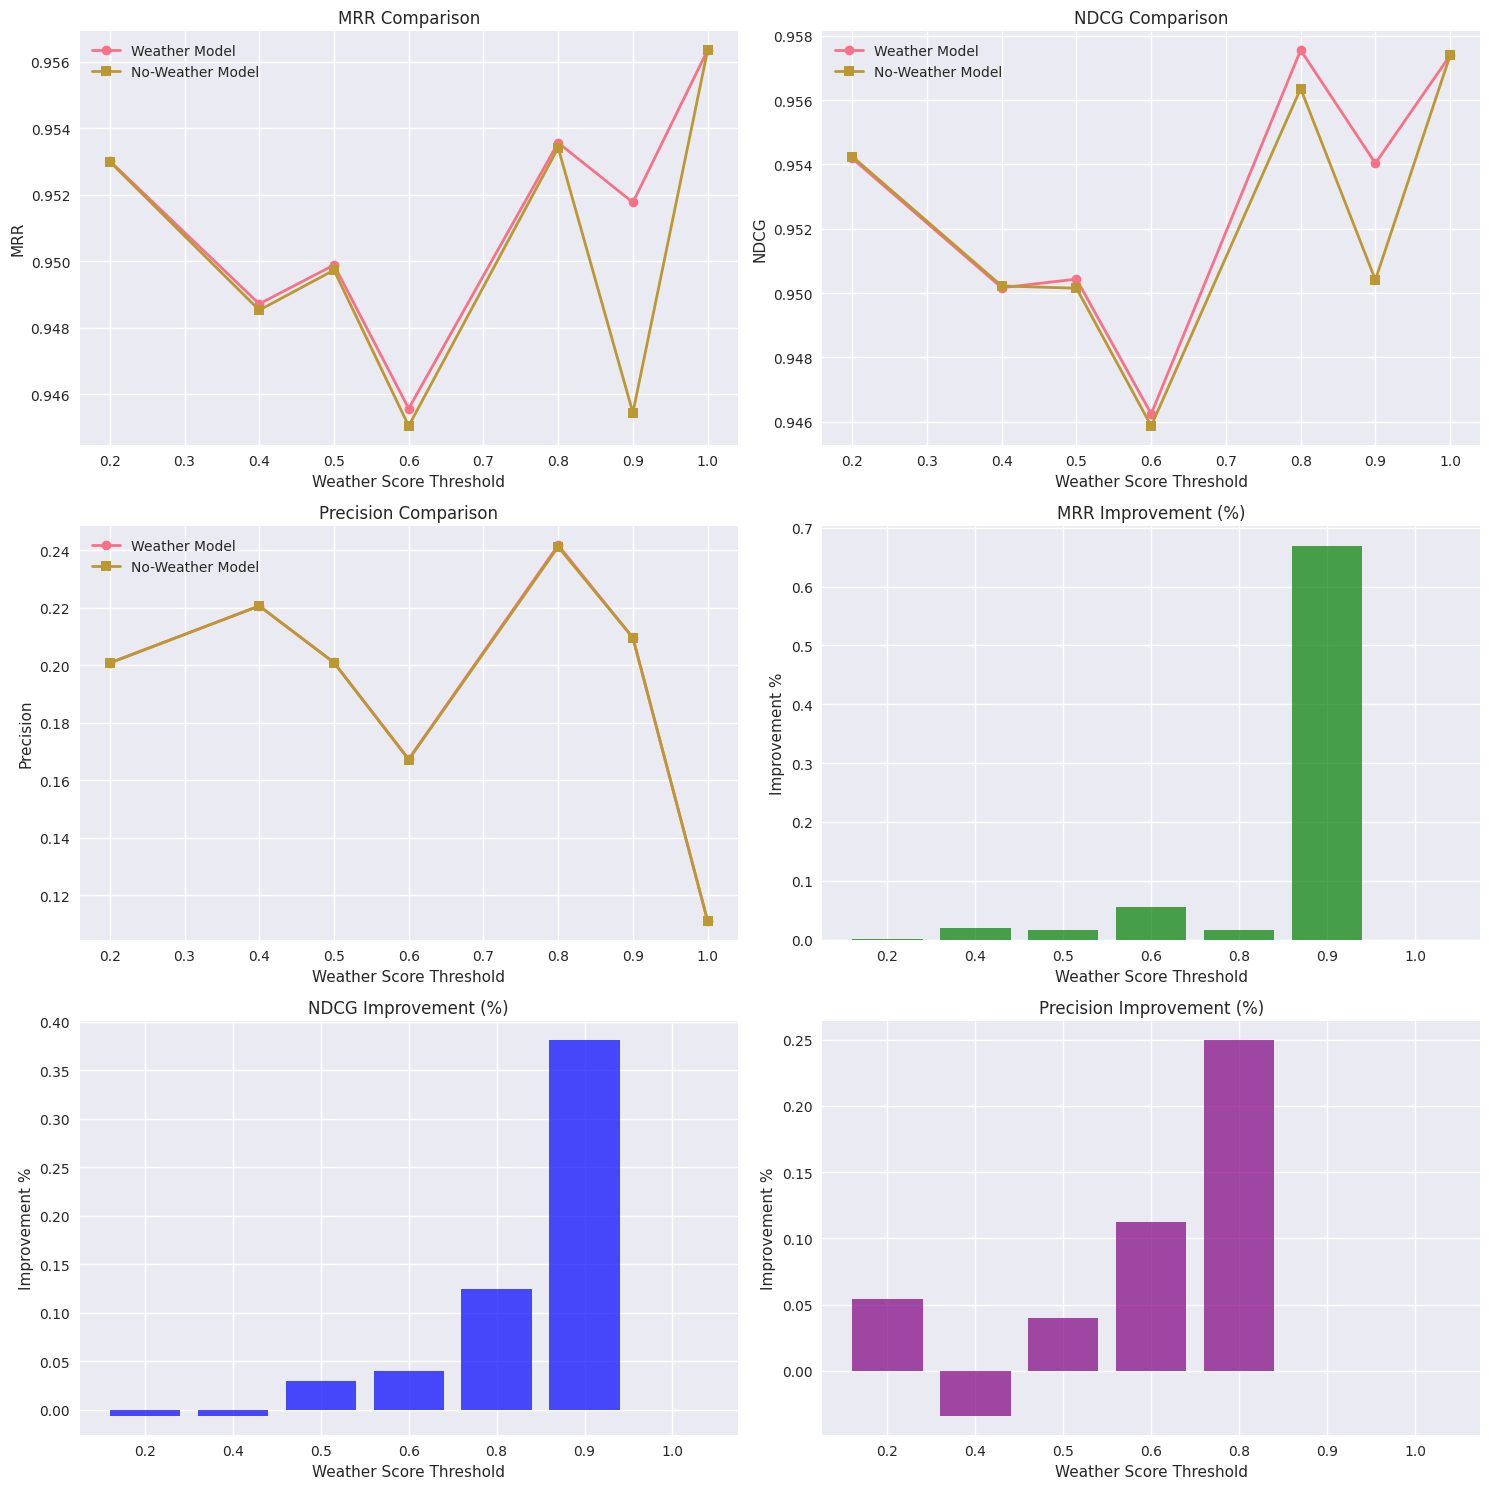

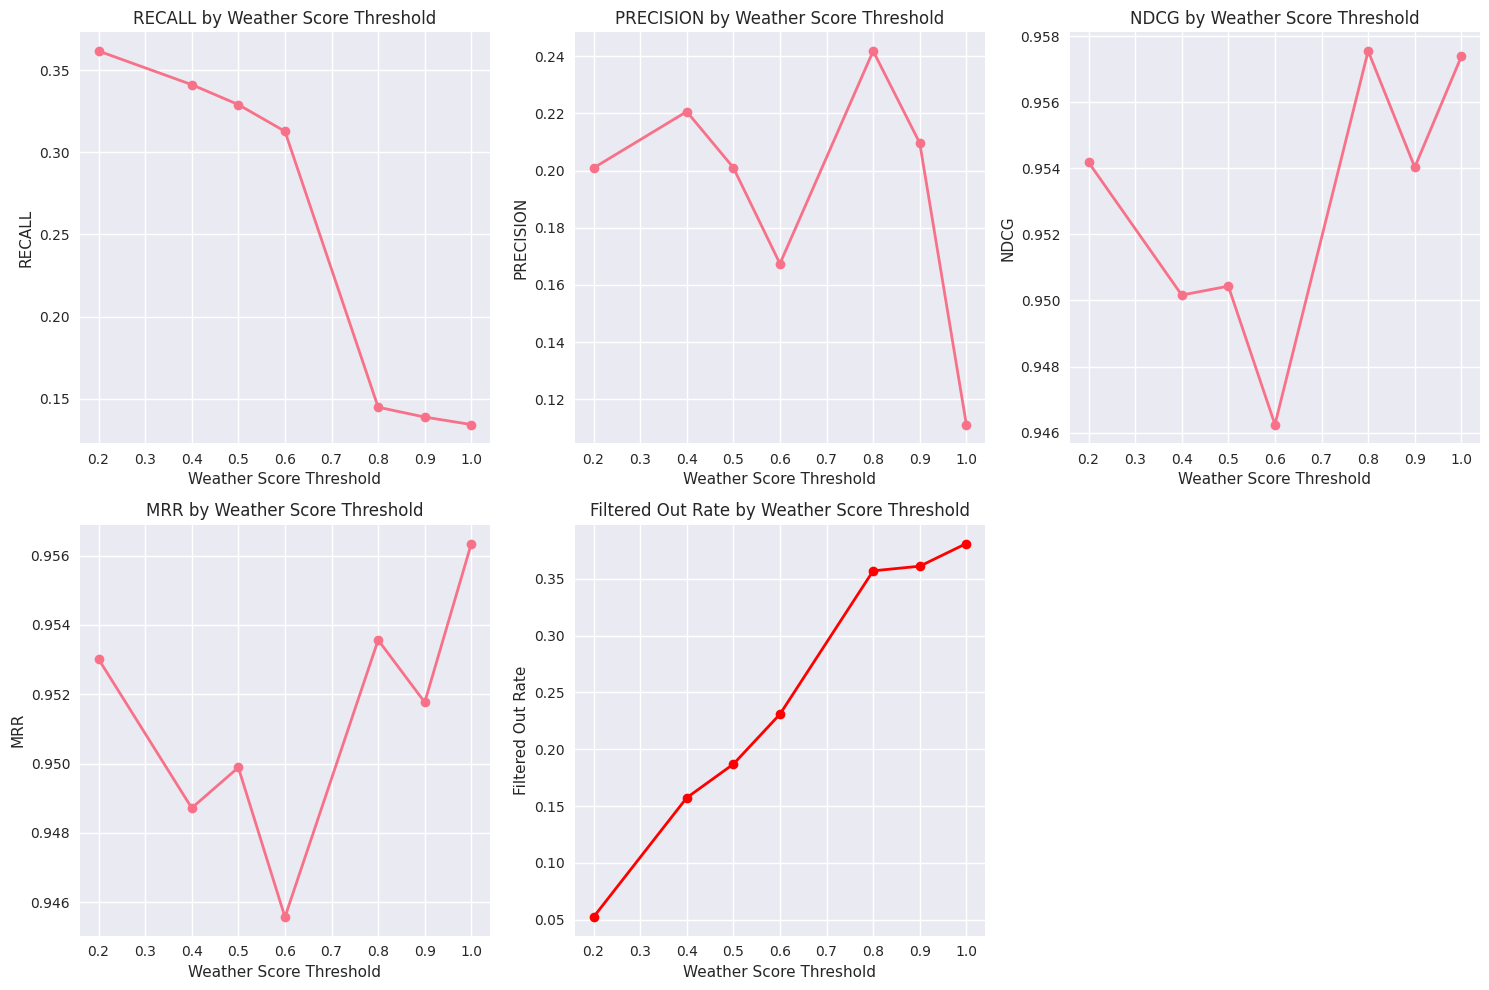

Weather features improve MRR by 0.11%
Weather features improve NDCG by 0.08%
Weather features improve Precision by 0.07%

Evaluation pipeline complete!


In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# --- Data loading and renaming (as in your paste.txt) ---


# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]
# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests']

# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Split data for evaluation
test_interactions = interactions_df.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def evaluate_weather_thresholds_comparison(
    query_model, candidate_model, weather_model, no_weather_model, test_interactions, 
    weather_features, no_weather_features, 
    k_retrieval=100, k=10, filter_time=True, max_distance_km=5000, 
    weather_score_thresholds=[0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
):
    print("\n=== Comparing Weather vs No-Weather Models Across Thresholds ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    # Initialize metrics storage for each threshold
    weather_results = {
        threshold: {
            "recall": [],
            "precision": [],
            "ndcg": [],
            "mrr": [],
            "total_users": 0,
            "successful_users": 0,
            "filtered_out_rate": []
        }
        for threshold in weather_score_thresholds
    }
    
    no_weather_results = {
        threshold: {
            "recall": [],
            "precision": [],
            "ndcg": [],
            "mrr": [],
            "total_users": 0,
            "successful_users": 0
        }
        for threshold in weather_score_thresholds
    }
    
    user_groups = test_interactions.groupby('user_id')
    total_users = 0
    
    for user_id, group in user_groups:
        try:
            total_users += 1
            
            # Get ground truth events the user actually interacted with
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            
            # Get events matching user interests
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            
            # Skip users with missing data
            if pd.isna(user_data['user_interests']):
                print(f"Skipping user {user_id} due to missing user_interests")
                continue
                
            user_interests = user_data['user_interests'].split(",")
            interest_matched = {
                ev_id for ev_id, ev_type in zip(events_df['event_id'], events_df['event_type'])
                if any(interest.strip().lower() in str(ev_type).lower() for interest in user_interests)
            }
            
            # Union of the two sets for relevance evaluation
            actual_relevant = attended_events.union(interest_matched)
            
            # Get user embedding and retrieve candidates
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
                
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            
            if retrieved_events_df.empty:
                continue
                
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='inner'
            )
            
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            
            # User context for weather filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            
            # Calculate weather scores for all candidates without filtering
            scores = []
            for _, event in merged.iterrows():
                score = compute_weather_match(
                    user_context.get('user_weather_condition', 'any'),
                    event.get('weather_condition', 'unknown'),
                    user_context.get('indoor_outdoor_preference', 'any'),
                    event.get('event_type', 'unknown'),
                    user_context.get('user_temperature', 20),
                    event.get('temperature', 20),
                    user_context.get('user_precipitation', 0),
                    event.get('precipitation_sum', 0)
                )
                scores.append(score)
            merged['weather_match_score'] = scores
            
            # Process each threshold for weather model
            for threshold in weather_score_thresholds:
                weather_results[threshold]["total_users"] += 1
                
                # Apply weather threshold filtering
                filtered_candidates = merged[merged['weather_match_score'] >= threshold].copy()
                
                # Calculate filtered out rate
                filtered_out_rate = 1 - (len(filtered_candidates) / len(merged)) if len(merged) > 0 else 0
                weather_results[threshold]["filtered_out_rate"].append(filtered_out_rate)
                
                if filtered_candidates.empty:
                    continue
                
                # Process weather model
                weather_recommendations = process_model_recommendations(
                    filtered_candidates, user_data, weather_model, weather_features, 
                    actual_relevant, attended_events, interest_matched, k
                )
                
                if weather_recommendations:
                    # Update weather metrics
                    weather_results[threshold]["recall"].append(weather_recommendations["recall"])
                    weather_results[threshold]["precision"].append(weather_recommendations["precision"])
                    weather_results[threshold]["ndcg"].append(weather_recommendations["ndcg"])
                    weather_results[threshold]["mrr"].append(weather_recommendations["mrr"])
                    weather_results[threshold]["successful_users"] += 1
                
                # Process no-weather model with same candidates
                no_weather_recommendations = process_model_recommendations(
                    filtered_candidates, user_data, no_weather_model, no_weather_features, 
                    actual_relevant, attended_events, interest_matched, k
                )
                
                if no_weather_recommendations:
                    # Update no-weather metrics
                    no_weather_results[threshold]["recall"].append(no_weather_recommendations["recall"])
                    no_weather_results[threshold]["precision"].append(no_weather_recommendations["precision"])
                    no_weather_results[threshold]["ndcg"].append(no_weather_recommendations["ndcg"])
                    no_weather_results[threshold]["mrr"].append(no_weather_recommendations["mrr"])
                    no_weather_results[threshold]["successful_users"] += 1
            
            if total_users % 100 == 0:
                print(f"Processed {total_users} users")
                
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    # Calculate average metrics for each threshold
    weather_summary = {}
    no_weather_summary = {}
    comparison = {}
    
    for threshold in weather_score_thresholds:
        # Weather metrics
        w_metrics = weather_results[threshold]
        w_recall = np.mean(w_metrics["recall"]) if w_metrics["recall"] else 0
        w_precision = np.mean(w_metrics["precision"]) if w_metrics["precision"] else 0
        w_ndcg = np.mean(w_metrics["ndcg"]) if w_metrics["ndcg"] else 0
        w_mrr = np.mean(w_metrics["mrr"]) if w_metrics["mrr"] else 0
        w_filtered_out_rate = np.mean(w_metrics["filtered_out_rate"]) if w_metrics["filtered_out_rate"] else 0
        
        weather_summary[threshold] = {
            "recall": w_recall,
            "precision": w_precision,
            "ndcg": w_ndcg,
            "mrr": w_mrr,
            "successful_users": w_metrics["successful_users"],
            "total_users": w_metrics["total_users"],
            "filtered_out_rate": w_filtered_out_rate
        }
        
        # No-weather metrics
        nw_metrics = no_weather_results[threshold]
        nw_recall = np.mean(nw_metrics["recall"]) if nw_metrics["recall"] else 0
        nw_precision = np.mean(nw_metrics["precision"]) if nw_metrics["precision"] else 0
        nw_ndcg = np.mean(nw_metrics["ndcg"]) if nw_metrics["ndcg"] else 0
        nw_mrr = np.mean(nw_metrics["mrr"]) if nw_metrics["mrr"] else 0
        
        no_weather_summary[threshold] = {
            "recall": nw_recall,
            "precision": nw_precision,
            "ndcg": nw_ndcg,
            "mrr": nw_mrr,
            "successful_users": nw_metrics["successful_users"],
            "total_users": nw_metrics["total_users"]
        }
        
        # Calculate improvement percentages
        if nw_mrr > 0:
            mrr_improvement = ((w_mrr - nw_mrr) / nw_mrr) * 100
        else:
            mrr_improvement = float('inf') if w_mrr > 0 else 0
            
        if nw_ndcg > 0:
            ndcg_improvement = ((w_ndcg - nw_ndcg) / nw_ndcg) * 100
        else:
            ndcg_improvement = float('inf') if w_ndcg > 0 else 0
            
        if nw_precision > 0:
            precision_improvement = ((w_precision - nw_precision) / nw_precision) * 100
        else:
            precision_improvement = float('inf') if w_precision > 0 else 0
            
        if nw_recall > 0:
            recall_improvement = ((w_recall - nw_recall) / nw_recall) * 100
        else:
            recall_improvement = float('inf') if w_recall > 0 else 0
            
        comparison[threshold] = {
            "mrr_improvement": mrr_improvement,
            "ndcg_improvement": ndcg_improvement,
            "precision_improvement": precision_improvement,
            "recall_improvement": recall_improvement,
            "weather_mrr": w_mrr,
            "no_weather_mrr": nw_mrr,
            "weather_ndcg": w_ndcg,
            "no_weather_ndcg": nw_ndcg,
            "weather_precision": w_precision,
            "no_weather_precision": nw_precision
        }
    
    # Convert to DataFrames for easier visualization
    weather_df = pd.DataFrame(weather_summary).T
    weather_df.index.name = 'Weather Score Threshold'
    
    no_weather_df = pd.DataFrame(no_weather_summary).T
    no_weather_df.index.name = 'Weather Score Threshold'
    
    comparison_df = pd.DataFrame(comparison).T
    comparison_df.index.name = 'Weather Score Threshold'
    
    # Print results
    print(f"\nEvaluation Results for k={k}:")
    print(f"Total users evaluated: {total_users}")
    
    print("\nWeather Model Metrics:")
    print(weather_df)
    
    print("\nNo-Weather Model Metrics:")
    print(no_weather_df)
    
    print("\nImprovement Percentages:")
    print(comparison_df[["mrr_improvement", "ndcg_improvement", "precision_improvement", "recall_improvement"]])
    
    # Plot comparison
    plt.figure(figsize=(15, 15))
    
    # MRR Comparison
    plt.subplot(3, 2, 1)
    plt.plot(weather_df.index, weather_df["mrr"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["mrr"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('MRR Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('MRR')
    plt.legend()
    plt.grid(True)
    
    # NDCG Comparison
    plt.subplot(3, 2, 2)
    plt.plot(weather_df.index, weather_df["ndcg"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["ndcg"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('NDCG Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('NDCG')
    plt.legend()
    plt.grid(True)
    
    # Precision Comparison
    plt.subplot(3, 2, 3)
    plt.plot(weather_df.index, weather_df["precision"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["precision"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('Precision Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    
    # MRR Improvement Percentages
    plt.subplot(3, 2, 4)
    plt.bar(comparison_df.index.astype(str), comparison_df["mrr_improvement"], color='green', alpha=0.7)
    plt.title('MRR Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    # NDCG Improvement Percentages
    plt.subplot(3, 2, 5)
    plt.bar(comparison_df.index.astype(str), comparison_df["ndcg_improvement"], color='blue', alpha=0.7)
    plt.title('NDCG Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    # Precision Improvement Percentages
    plt.subplot(3, 2, 6)
    plt.bar(comparison_df.index.astype(str), comparison_df["precision_improvement"], color='purple', alpha=0.7)
    plt.title('Precision Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('weather_vs_no_weather_comparison.png')
    plt.show()
    
    # Plot individual metrics
    plt.figure(figsize=(15, 10))
    
    # RECALL by Weather Score Threshold
    plt.subplot(2, 3, 1)
    plt.plot(weather_df.index, weather_df["recall"], marker='o', linewidth=2)
    plt.title('RECALL by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('RECALL')
    plt.grid(True)
    
    # PRECISION by Weather Score Threshold
    plt.subplot(2, 3, 2)
    plt.plot(weather_df.index, weather_df["precision"], marker='o', linewidth=2)
    plt.title('PRECISION by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('PRECISION')
    plt.grid(True)
    
    # NDCG by Weather Score Threshold
    plt.subplot(2, 3, 3)
    plt.plot(weather_df.index, weather_df["ndcg"], marker='o', linewidth=2)
    plt.title('NDCG by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('NDCG')
    plt.grid(True)
    
    # MRR by Weather Score Threshold
    plt.subplot(2, 3, 4)
    plt.plot(weather_df.index, weather_df["mrr"], marker='o', linewidth=2)
    plt.title('MRR by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('MRR')
    plt.grid(True)
    
    # Filtered Out Rate by Weather Score Threshold
    plt.subplot(2, 3, 5)
    plt.plot(weather_df.index, weather_df["filtered_out_rate"], marker='o', linewidth=2, color='red')
    plt.title('Filtered Out Rate by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Filtered Out Rate')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('weather_metrics_by_threshold.png')
    plt.show()
    
    return weather_df, no_weather_df, comparison_df

def process_model_recommendations(candidates_df, user_data, model, feature_list, actual_relevant, attended_events, interest_matched, k):
    """Helper function to process model recommendations and calculate metrics"""
    try:
        # Prepare data for ranking
        ranking_data = []
        for _, event in candidates_df.iterrows():
            row = {
                'event_id': event['event_id'],
                'event_type': event['event_type'],
                'event_city': event['event_city'],
                'attendance_rate': event['attendance_rate'],
                'event_indoor_capability': event['event_indoor_capability'],
                'user_city': user_data['user_city'],
                'age': user_data['age'],
                'user_interests': user_data['user_interests']
            }
            if 'weather_condition' in feature_list:
                row['weather_condition'] = event['weather_condition']
                row['temperature'] = event['temperature']
                row['indoor_outdoor_preference'] = user_data['indoor_outdoor_preference']
            row['interaction_distance_to_event'] = event['interaction_distance_to_event']
            ranking_data.append(row)
        
        ranking_df = pd.DataFrame(ranking_data)
        
        # Fill missing features
        for feat in feature_list:
            if feat not in ranking_df.columns:
                if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition']:
                    ranking_df[feat] = 'unknown'
                elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                    ranking_df[feat] = 0.0
                elif feat == 'age':
                    ranking_df[feat] = 30
                elif feat == 'event_indoor_capability':
                    ranking_df[feat] = True
        
        # Prepare features for ranking model
        text_cols = ["title", "user_interests"]
        ranking_features = ranking_df[feature_list].drop(columns=[c for c in text_cols if c in ranking_df.columns])
        
        for col in ranking_features.columns:
            if ranking_features[col].dtype == 'object':
                ranking_features[col] = ranking_features[col].fillna('unknown')
            elif ranking_features[col].dtype in ['float64', 'float32']:
                ranking_features[col] = ranking_features[col].fillna(0.0)
            elif ranking_features[col].dtype in ['int64', 'int32']:
                ranking_features[col] = ranking_features[col].fillna(0)
            elif ranking_features[col].dtype == 'bool':
                ranking_features[col] = ranking_features[col].fillna(False)
        
        cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
        ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
        ranking_scores = model.predict_proba(ranking_pool)[:, 1]
        ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
        ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
        final_recommendation_ids = ranked_results['event_id'].tolist()[:k]
        
        if not final_recommendation_ids:
            return None
        
        # Calculate metrics
        top_k = set(final_recommendation_ids)
        
        # Calculate other metrics
        hits = len(top_k.intersection(actual_relevant))
        recall = hits / len(actual_relevant) if actual_relevant else 0
        precision = hits / k if k > 0 else 0
        
        # NDCG calculation
        relevance = [1 if eid in actual_relevant else 0 for eid in final_recommendation_ids]
        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
        ideal_relevance = sorted(relevance, reverse=True)
        idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
        ndcg = dcg / idcg if idcg > 0 else 0
        
        # MRR calculation
        mrr = 0
        for i, eid in enumerate(final_recommendation_ids):
            if eid in actual_relevant:
                mrr = 1.0 / (i + 1)
                break
        
        return {
            "recall": recall,
            "precision": precision,
            "ndcg": ndcg,
            "mrr": mrr
        }
    except Exception as e:
        print(f"Error processing recommendations: {e}")
        return None

def main():
    print("Starting evaluation pipeline for weather score threshold impact...")
    print(f"Current date: Sunday, May 18, 2025, 1:13 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    # Define weather score thresholds to evaluate
    weather_thresholds = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
    
    # Evaluate impact of weather score thresholds with comparison to no-weather model
    weather_df, no_weather_df, comparison_df = evaluate_weather_thresholds_comparison(
        query_model,
        candidate_model,
        weather_model,
        no_weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        k=10,  # Fixed k for evaluation
        filter_time=False,
        max_distance_km=500,
        weather_score_thresholds=weather_thresholds
    )
    
    #Save results
    weather_df.to_csv("weather_model_results.csv")
    no_weather_df.to_csv("no_weather_model_results.csv")
    comparison_df.to_csv("model_comparison_results.csv")
    
    # Calculate overall improvement for all metrics
    if weather_df["mrr"].mean() > no_weather_df["mrr"].mean():
        mrr_improvement = ((weather_df["mrr"].mean() - no_weather_df["mrr"].mean()) / no_weather_df["mrr"].mean()) * 100
        print(f"Weather features improve MRR by {mrr_improvement:.2f}%")
    else:
        mrr_diff = ((no_weather_df["mrr"].mean() - weather_df["mrr"].mean()) / weather_df["mrr"].mean()) * 100
        print(f"Weather features decrease MRR by {mrr_diff:.2f}%")
        
    if weather_df["ndcg"].mean() > no_weather_df["ndcg"].mean():
        ndcg_improvement = ((weather_df["ndcg"].mean() - no_weather_df["ndcg"].mean()) / no_weather_df["ndcg"].mean()) * 100
        print(f"Weather features improve NDCG by {ndcg_improvement:.2f}%")
    else:
        ndcg_diff = ((no_weather_df["ndcg"].mean() - weather_df["ndcg"].mean()) / weather_df["ndcg"].mean()) * 100
        print(f"Weather features decrease NDCG by {ndcg_diff:.2f}%")
        
    if weather_df["precision"].mean() > no_weather_df["precision"].mean():
        precision_improvement = ((weather_df["precision"].mean() - no_weather_df["precision"].mean()) / no_weather_df["precision"].mean()) * 100
        print(f"Weather features improve Precision by {precision_improvement:.2f}%")
    else:
        precision_diff = ((no_weather_df["precision"].mean() - weather_df["precision"].mean()) / weather_df["precision"].mean()) * 100
        print(f"Weather features decrease Precision by {precision_diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")

if __name__ == "__main__":
    main()
